In [1]:
import torch
import torch.nn as nn
from utils import data_loader
from vae_classifier_attacks import test_attack, fgsm_attack
import pickle
from utils.viewer import show_batch
import matplotlib.pyplot as plt
from utils.mmd import MMD_torch

In [2]:
train_set, test_set = data_loader.get_data()
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [3]:
class NeuralModel(nn.Module):
    def __init__(self):
        super().__init__()

        num_channels = 8

        self.conv = nn.Sequential(

            nn.Conv2d(1, num_channels, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.5, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.5, affine=True),
            nn.ReLU(inplace=True),

            nn.Conv2d(num_channels, num_channels, kernel_size=5),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.5, affine=True),
            nn.ReLU(inplace=True)

        )
        self.fc1 = nn.Linear(num_channels * 4 ** 2, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        convolved = self.conv(x)
        after_fc1 = self.fc1(convolved.view(convolved.size(0), -1))
        output = self.fc2(after_fc1)
        return output
    
    def encode(self, x):
        
        convolved = self.conv(x)
        code = self.fc1(convolved.view(convolved.size(0), -1))
        
        return code
         


In [4]:

train_loader = torch.utils.data.DataLoader(train_set, batch_size=512)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512)

first_batch = next(iter(train_loader))
first_images, first_labels = first_batch 

print(first_images.dtype)



torch.float32


In [5]:
#model = NeuralModel()
#train_model(model, train_loader)
#test_model(model, test_loader)

In [6]:
eps = 0.3

In [7]:
# test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)
# train_loader = torch.utils.data.DataLoader(train_set, batch_size=1)
# #acc, adv_examples = test_attack(model, device, train_loader, epsilon=eps)

In [8]:
#print(len(adv_examples))

In [9]:
# with open('models/train_adv_examples.pkl', 'wb') as f:
#     pickle.dump(adv_examples, f)

In [10]:
with open('models/train_adv_examples.pkl', 'rb') as f:
    adv_examples = pickle.load(f)

In [11]:
true_labels =[]
adv_labels = [] 
adv_images =[]

In [12]:
for example in adv_examples:
    true_l, adv_l, adv_img = example
    
    true_labels.append(true_l)
    adv_labels.append(adv_l)
    adv_images.append(adv_img)

In [13]:
true_labels = torch.Tensor(true_labels).long()
adv_images = torch.Tensor(adv_images).reshape(-1,1,28,28)

In [14]:
b_size = 60
training_data = []
train_loader = torch.utils.data.DataLoader(train_set, batch_size=b_size)
print(len(train_loader))

1000


In [15]:
train_loader_iter = iter(train_loader)

for b in range (0, len(train_loader)*b_size, b_size):
    batch_images, batch_labels = next(train_loader_iter)
    training_data.append((batch_images, adv_images[b: b+b_size], true_labels[b: b+b_size]))

60
60
60


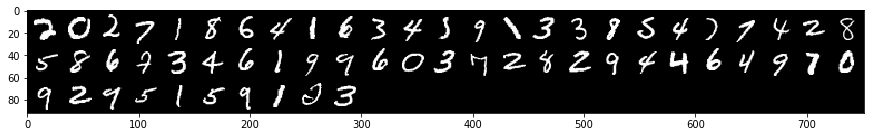

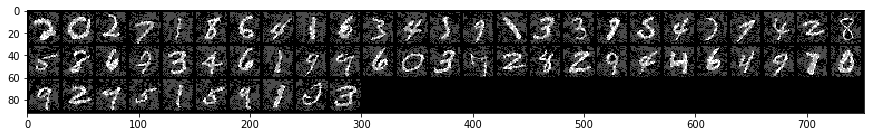

tensor([7, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 1, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2,
        8, 5, 8, 6, 9, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9,
        7, 0, 9, 2, 7, 5, 1, 5, 9, 1, 2, 3])


In [16]:
training_data_iter = iter(training_data)
b1 = next(training_data_iter)
b1 = next(training_data_iter)
b1 = next(training_data_iter)
a,b,c = b1

print(len(a))
print(len(b))
print(len(c))

show_batch(a)
show_batch(b)
print(c)

In [23]:
def train_model(model, train_data):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    n_epochs = 10
    model.train()
    
    model.to(device)
    
    print("training ...")
    for epoch in range(n_epochs):
        for batch in train_data:
            batch_images, adv_images, batch_labels = batch

            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            adv_images = adv_images.to(device)
            
            batch_output = model(batch_images)
            
            latent_1 = model.encode(batch_images)
            latent_2 = model.encode(adv_images)
            
            down_stream_loss = criterion(batch_output, batch_labels)
            representation_loss = MMD_Loss(latent_1, latent_2)
            
            total_loss = down_stream_loss + 100*representation_loss
            
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            print("The classification loss after processing this batch is: ", down_stream_loss.item())
            print("The representation loss after processing this batch is: ", representation_loss.item())
            print("")
            
    print("Done training..")
    print("=*="*20)
    return model



In [24]:

def MMD_Loss(x, y):
    
    alpha =1
    B=b_size

    x = x.view(x.size(0), x.size(1) * 1)
    y = y.view(y.size(0), y.size(1) * 1)

    xx, yy, zz = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    K = torch.exp(- alpha * (rx.t() + rx - 2*xx))
    L = torch.exp(- alpha * (ry.t() + ry - 2*yy))
    P = torch.exp(- alpha * (rx.t() + ry - 2*zz))

    beta = (1./(B*(B-1)))
    gamma = (2./(B*B)) 

    return beta * (torch.sum(K)+torch.sum(L)) - gamma * torch.sum(P)

In [25]:
modelMM = NeuralModel()
model = train_model(modelMM, training_data)

training ...
The classification loss after processing this batch is:  2.319800853729248
The representation loss after processing this batch is:  0.03756791353225708

The classification loss after processing this batch is:  2.3250112533569336
The representation loss after processing this batch is:  0.03828895092010498

The classification loss after processing this batch is:  2.3251535892486572
The representation loss after processing this batch is:  0.031454771757125854

The classification loss after processing this batch is:  2.315671682357788
The representation loss after processing this batch is:  0.02934589982032776

The classification loss after processing this batch is:  2.319268226623535
The representation loss after processing this batch is:  0.03258591890335083

The classification loss after processing this batch is:  2.3162291049957275
The representation loss after processing this batch is:  0.03440070152282715

The classification loss after processing this batch is:  2.297881

The classification loss after processing this batch is:  2.1354401111602783
The representation loss after processing this batch is:  0.014337092638015747

The classification loss after processing this batch is:  2.098585367202759
The representation loss after processing this batch is:  0.017018407583236694

The classification loss after processing this batch is:  2.136108636856079
The representation loss after processing this batch is:  0.016084909439086914

The classification loss after processing this batch is:  2.0768964290618896
The representation loss after processing this batch is:  0.017725318670272827

The classification loss after processing this batch is:  2.1157777309417725
The representation loss after processing this batch is:  0.014912158250808716

The classification loss after processing this batch is:  2.084702491760254
The representation loss after processing this batch is:  0.01344558596611023

The classification loss after processing this batch is:  2.080302953720092

The classification loss after processing this batch is:  1.920264482498169
The representation loss after processing this batch is:  0.010343819856643677

The classification loss after processing this batch is:  1.87166428565979
The representation loss after processing this batch is:  0.010343357920646667

The classification loss after processing this batch is:  1.8795208930969238
The representation loss after processing this batch is:  0.009350091218948364

The classification loss after processing this batch is:  1.9562705755233765
The representation loss after processing this batch is:  0.009449213743209839

The classification loss after processing this batch is:  1.868042230606079
The representation loss after processing this batch is:  0.008636385202407837

The classification loss after processing this batch is:  1.7994238138198853
The representation loss after processing this batch is:  0.008538365364074707

The classification loss after processing this batch is:  1.869121789932251

The representation loss after processing this batch is:  0.00855591893196106

The classification loss after processing this batch is:  1.5752123594284058
The representation loss after processing this batch is:  0.00755879282951355

The classification loss after processing this batch is:  1.6637749671936035
The representation loss after processing this batch is:  0.007704630494117737

The classification loss after processing this batch is:  1.6456717252731323
The representation loss after processing this batch is:  0.006956204771995544

The classification loss after processing this batch is:  1.6030638217926025
The representation loss after processing this batch is:  0.008535295724868774

The classification loss after processing this batch is:  1.6609052419662476
The representation loss after processing this batch is:  0.006873533129692078

The classification loss after processing this batch is:  1.5692542791366577
The representation loss after processing this batch is:  0.0080147236585

The classification loss after processing this batch is:  1.2145925760269165
The representation loss after processing this batch is:  0.00673520565032959

The classification loss after processing this batch is:  1.1593966484069824
The representation loss after processing this batch is:  0.007650889456272125

The classification loss after processing this batch is:  1.2576487064361572
The representation loss after processing this batch is:  0.00726751983165741

The classification loss after processing this batch is:  1.224829912185669
The representation loss after processing this batch is:  0.008306607604026794

The classification loss after processing this batch is:  1.42558753490448
The representation loss after processing this batch is:  0.007785633206367493

The classification loss after processing this batch is:  1.472212314605713
The representation loss after processing this batch is:  0.009179383516311646

The classification loss after processing this batch is:  1.2930431365966797


The classification loss after processing this batch is:  0.9711796045303345
The representation loss after processing this batch is:  0.0065604448318481445

The classification loss after processing this batch is:  1.1254234313964844
The representation loss after processing this batch is:  0.005835697054862976

The classification loss after processing this batch is:  1.074142575263977
The representation loss after processing this batch is:  0.006791949272155762

The classification loss after processing this batch is:  1.2126059532165527
The representation loss after processing this batch is:  0.005660459399223328

The classification loss after processing this batch is:  1.198702335357666
The representation loss after processing this batch is:  0.006512239575386047

The classification loss after processing this batch is:  1.215194821357727
The representation loss after processing this batch is:  0.006140194833278656

The classification loss after processing this batch is:  1.1635144948959

The classification loss after processing this batch is:  0.9689480066299438
The representation loss after processing this batch is:  0.006605528295040131

The classification loss after processing this batch is:  0.9171541929244995
The representation loss after processing this batch is:  0.006029855459928513

The classification loss after processing this batch is:  0.8475178480148315
The representation loss after processing this batch is:  0.006571829319000244

The classification loss after processing this batch is:  0.859370768070221
The representation loss after processing this batch is:  0.005405552685260773

The classification loss after processing this batch is:  0.7967987656593323
The representation loss after processing this batch is:  0.0057340338826179504

The classification loss after processing this batch is:  0.8246837854385376
The representation loss after processing this batch is:  0.006485573947429657

The classification loss after processing this batch is:  0.84700798988

The classification loss after processing this batch is:  0.9698308110237122
The representation loss after processing this batch is:  0.008210241794586182

The classification loss after processing this batch is:  0.8082716464996338
The representation loss after processing this batch is:  0.007566813379526138

The classification loss after processing this batch is:  0.6831615567207336
The representation loss after processing this batch is:  0.005384698510169983

The classification loss after processing this batch is:  0.8860825300216675
The representation loss after processing this batch is:  0.005989100784063339

The classification loss after processing this batch is:  0.7643291354179382
The representation loss after processing this batch is:  0.004569090902805328

The classification loss after processing this batch is:  0.6138018369674683
The representation loss after processing this batch is:  0.005693189799785614

The classification loss after processing this batch is:  0.66331869363

The classification loss after processing this batch is:  0.7438240051269531
The representation loss after processing this batch is:  0.00512261688709259

The classification loss after processing this batch is:  0.5746616721153259
The representation loss after processing this batch is:  0.005364805459976196

The classification loss after processing this batch is:  0.6020199656486511
The representation loss after processing this batch is:  0.006261102855205536

The classification loss after processing this batch is:  0.5379897356033325
The representation loss after processing this batch is:  0.005498230457305908

The classification loss after processing this batch is:  0.5682657957077026
The representation loss after processing this batch is:  0.005823850631713867

The classification loss after processing this batch is:  0.5916964411735535
The representation loss after processing this batch is:  0.005948506295681

The classification loss after processing this batch is:  0.776691496372222

The classification loss after processing this batch is:  0.6050278544425964
The representation loss after processing this batch is:  0.004898961633443832

The classification loss after processing this batch is:  0.5831270813941956
The representation loss after processing this batch is:  0.004876170307397842

The classification loss after processing this batch is:  0.6581094264984131
The representation loss after processing this batch is:  0.005616530776023865

The classification loss after processing this batch is:  0.587952733039856
The representation loss after processing this batch is:  0.005774170160293579

The classification loss after processing this batch is:  0.5952185988426208
The representation loss after processing this batch is:  0.005523018538951874

The classification loss after processing this batch is:  0.6080309152603149
The representation loss after processing this batch is:  0.006714373826980591

The classification loss after processing this batch is:  0.607813000679

The classification loss after processing this batch is:  0.6610720157623291
The representation loss after processing this batch is:  0.0047695934772491455

The classification loss after processing this batch is:  0.6773338913917542
The representation loss after processing this batch is:  0.005244165658950806

The classification loss after processing this batch is:  0.815255343914032
The representation loss after processing this batch is:  0.005447253584861755

The classification loss after processing this batch is:  0.659800112247467
The representation loss after processing this batch is:  0.0053192079067230225

The classification loss after processing this batch is:  0.7003529667854309
The representation loss after processing this batch is:  0.0045744627714157104

The classification loss after processing this batch is:  0.6015040874481201
The representation loss after processing this batch is:  0.0049385130405426025

The classification loss after processing this batch is:  0.586422622

The classification loss after processing this batch is:  0.5176793336868286
The representation loss after processing this batch is:  0.005013063549995422

The classification loss after processing this batch is:  0.42261311411857605
The representation loss after processing this batch is:  0.005269952118396759

The classification loss after processing this batch is:  0.3383726477622986
The representation loss after processing this batch is:  0.005317695438861847

The classification loss after processing this batch is:  0.5105560421943665
The representation loss after processing this batch is:  0.005814515054225922

The classification loss after processing this batch is:  0.4966897666454315
The representation loss after processing this batch is:  0.004570186138153076

The classification loss after processing this batch is:  0.5746561884880066
The representation loss after processing this batch is:  0.004297226667404175

The classification loss after processing this batch is:  0.4176875054

The classification loss after processing this batch is:  0.43439409136772156
The representation loss after processing this batch is:  0.005492553114891052

The classification loss after processing this batch is:  0.39597728848457336
The representation loss after processing this batch is:  0.004947654902935028

The classification loss after processing this batch is:  0.5872427821159363
The representation loss after processing this batch is:  0.005702860653400421

The classification loss after processing this batch is:  0.44374048709869385
The representation loss after processing this batch is:  0.004634328186511993

The classification loss after processing this batch is:  0.4051796793937683
The representation loss after processing this batch is:  0.005434289574623108

The classification loss after processing this batch is:  0.505027174949646
The representation loss after processing this batch is:  0.004464864730834961

The classification loss after processing this batch is:  0.355468660

The classification loss after processing this batch is:  0.6890037655830383
The representation loss after processing this batch is:  0.005165651440620422

The classification loss after processing this batch is:  0.6065201163291931
The representation loss after processing this batch is:  0.004409469664096832

The classification loss after processing this batch is:  0.39771080017089844
The representation loss after processing this batch is:  0.004424974322319031

The classification loss after processing this batch is:  0.3377018868923187
The representation loss after processing this batch is:  0.004681341350078583

The classification loss after processing this batch is:  0.3381550908088684
The representation loss after processing this batch is:  0.0045365020632743835

The classification loss after processing this batch is:  0.3532212972640991
The representation loss after processing this batch is:  0.004500746726989746

The classification loss after processing this batch is:  0.472189337

The classification loss after processing this batch is:  0.25018492341041565
The representation loss after processing this batch is:  0.005889378488063812

The classification loss after processing this batch is:  0.6601131558418274
The representation loss after processing this batch is:  0.005667954683303833

The classification loss after processing this batch is:  0.6207292079925537
The representation loss after processing this batch is:  0.00515630841255188

The classification loss after processing this batch is:  0.4802708923816681
The representation loss after processing this batch is:  0.005741387605667114

The classification loss after processing this batch is:  0.24922701716423035
The representation loss after processing this batch is:  0.0047830864787101746

The classification loss after processing this batch is:  0.22682085633277893
The representation loss after processing this batch is:  0.005721554160118103

The classification loss after processing this batch is:  0.24621371

The classification loss after processing this batch is:  0.28498607873916626
The representation loss after processing this batch is:  0.0037676170468330383

The classification loss after processing this batch is:  0.2863256633281708
The representation loss after processing this batch is:  0.004691660404205322

The classification loss after processing this batch is:  0.35265466570854187
The representation loss after processing this batch is:  0.004488419741392136

The classification loss after processing this batch is:  0.38844138383865356
The representation loss after processing this batch is:  0.004156298935413361

The classification loss after processing this batch is:  0.32687288522720337
The representation loss after processing this batch is:  0.00481172651052475

The classification loss after processing this batch is:  0.33461421728134155
The representation loss after processing this batch is:  0.004204601049423218

The classification loss after processing this batch is:  0.351980

The classification loss after processing this batch is:  0.35691720247268677
The representation loss after processing this batch is:  0.0037936903536319733

The classification loss after processing this batch is:  0.37504270672798157
The representation loss after processing this batch is:  0.0035352520644664764

The classification loss after processing this batch is:  0.3976905941963196
The representation loss after processing this batch is:  0.004499394446611404

The classification loss after processing this batch is:  0.2726227641105652
The representation loss after processing this batch is:  0.004551805555820465

The classification loss after processing this batch is:  0.3930634558200836
The representation loss after processing this batch is:  0.0043359920382499695

The classification loss after processing this batch is:  0.39252060651779175
The representation loss after processing this batch is:  0.004430606961250305

The classification loss after processing this batch is:  0.45158

The classification loss after processing this batch is:  0.34183967113494873
The representation loss after processing this batch is:  0.004322823137044907

The classification loss after processing this batch is:  0.3397722840309143
The representation loss after processing this batch is:  0.003884732723236084

The classification loss after processing this batch is:  0.3514677584171295
The representation loss after processing this batch is:  0.0047483667731285095

The classification loss after processing this batch is:  0.37827837467193604
The representation loss after processing this batch is:  0.0039133355021476746

The classification loss after processing this batch is:  0.4563814699649811
The representation loss after processing this batch is:  0.0041282884776592255

The classification loss after processing this batch is:  0.4276729226112366
The representation loss after processing this batch is:  0.004081033170223236

The classification loss after processing this batch is:  0.490107

The classification loss after processing this batch is:  0.22234807908535004
The representation loss after processing this batch is:  0.0040376558899879456

The classification loss after processing this batch is:  0.271830677986145
The representation loss after processing this batch is:  0.004063256084918976

The classification loss after processing this batch is:  0.28345730900764465
The representation loss after processing this batch is:  0.004334747791290283

The classification loss after processing this batch is:  0.2797875702381134
The representation loss after processing this batch is:  0.004249878227710724

The classification loss after processing this batch is:  0.35463032126426697
The representation loss after processing this batch is:  0.003799818456172943

The classification loss after processing this batch is:  0.29134857654571533
The representation loss after processing this batch is:  0.004667617380619049

The classification loss after processing this batch is:  0.3378817

The classification loss after processing this batch is:  0.42359456419944763
The representation loss after processing this batch is:  0.003907695412635803

The classification loss after processing this batch is:  0.319124311208725
The representation loss after processing this batch is:  0.004180997610092163

The classification loss after processing this batch is:  0.4128306210041046
The representation loss after processing this batch is:  0.004113372415304184

The classification loss after processing this batch is:  0.36404818296432495
The representation loss after processing this batch is:  0.004174955189228058

The classification loss after processing this batch is:  0.21472541987895966
The representation loss after processing this batch is:  0.00408017635345459

The classification loss after processing this batch is:  0.3531538248062134
The representation loss after processing this batch is:  0.0039505138993263245

The classification loss after processing this batch is:  0.209091588

The classification loss after processing this batch is:  0.2981313467025757
The representation loss after processing this batch is:  0.004192769527435303

The classification loss after processing this batch is:  0.2654053270816803
The representation loss after processing this batch is:  0.003943294286727905

The classification loss after processing this batch is:  0.33820030093193054
The representation loss after processing this batch is:  0.004312235862016678

The classification loss after processing this batch is:  0.2570157051086426
The representation loss after processing this batch is:  0.004411101341247559

The classification loss after processing this batch is:  0.23828966915607452
The representation loss after processing this batch is:  0.004467308521270752

The classification loss after processing this batch is:  0.3163190484046936
The representation loss after processing this batch is:  0.004866085946559906

The classification loss after processing this batch is:  0.207337290

The classification loss after processing this batch is:  0.29447534680366516
The representation loss after processing this batch is:  0.003932565450668335

The classification loss after processing this batch is:  0.27725949883461
The representation loss after processing this batch is:  0.004256486892700195

The classification loss after processing this batch is:  0.23598922789096832
The representation loss after processing this batch is:  0.0045800358057022095

The classification loss after processing this batch is:  0.3740083873271942
The representation loss after processing this batch is:  0.0035874247550964355

The classification loss after processing this batch is:  0.5537524819374084
The representation loss after processing this batch is:  0.003934845328330994

The classification loss after processing this batch is:  0.27766433358192444
The representation loss after processing this batch is:  0.004237540066242218

The classification loss after processing this batch is:  0.48465040

The classification loss after processing this batch is:  0.3238828778266907
The representation loss after processing this batch is:  0.0038304775953292847

The classification loss after processing this batch is:  0.1866198480129242
The representation loss after processing this batch is:  0.003621138632297516

The classification loss after processing this batch is:  0.17817085981369019
The representation loss after processing this batch is:  0.003864087164402008

The classification loss after processing this batch is:  0.26798883080482483
The representation loss after processing this batch is:  0.003962039947509766

The classification loss after processing this batch is:  0.28809547424316406
The representation loss after processing this batch is:  0.004447735846042633

The classification loss after processing this batch is:  0.25459566712379456
The representation loss after processing this batch is:  0.004049248993396759

The classification loss after processing this batch is:  0.227408

The classification loss after processing this batch is:  0.24647535383701324
The representation loss after processing this batch is:  0.0038891062140464783

The classification loss after processing this batch is:  0.25411897897720337
The representation loss after processing this batch is:  0.004128977656364441

The classification loss after processing this batch is:  0.24582165479660034
The representation loss after processing this batch is:  0.0034016743302345276

The classification loss after processing this batch is:  0.24102789163589478
The representation loss after processing this batch is:  0.0036438480019569397

The classification loss after processing this batch is:  0.2938254177570343
The representation loss after processing this batch is:  0.004047617316246033

The classification loss after processing this batch is:  0.3032855689525604
The representation loss after processing this batch is:  0.003986235707998276

The classification loss after processing this batch is:  0.2915

The classification loss after processing this batch is:  0.33947545289993286
The representation loss after processing this batch is:  0.0035604089498519897

The classification loss after processing this batch is:  0.23590412735939026
The representation loss after processing this batch is:  0.0041786134243011475

The classification loss after processing this batch is:  0.38268500566482544
The representation loss after processing this batch is:  0.003829341381788254

The classification loss after processing this batch is:  0.39420977234840393
The representation loss after processing this batch is:  0.004084691405296326

The classification loss after processing this batch is:  0.14567089080810547
The representation loss after processing this batch is:  0.0032309219241142273

The classification loss after processing this batch is:  0.18277835845947266
The representation loss after processing this batch is:  0.003779679536819458

The classification loss after processing this batch is:  0.37

The classification loss after processing this batch is:  0.2015213668346405
The representation loss after processing this batch is:  0.0038957297801971436

The classification loss after processing this batch is:  0.3433596193790436
The representation loss after processing this batch is:  0.003085523843765259

The classification loss after processing this batch is:  0.17604531347751617
The representation loss after processing this batch is:  0.003907114267349243

The classification loss after processing this batch is:  0.2141633778810501
The representation loss after processing this batch is:  0.003440171480178833

The classification loss after processing this batch is:  0.2771992087364197
The representation loss after processing this batch is:  0.0040198564529418945

The classification loss after processing this batch is:  0.22274088859558105
The representation loss after processing this batch is:  0.0032498762011528015

The classification loss after processing this batch is:  0.312959

The classification loss after processing this batch is:  0.1446932852268219
The representation loss after processing this batch is:  0.003491811454296112

The classification loss after processing this batch is:  0.20308643579483032
The representation loss after processing this batch is:  0.003702796995639801

The classification loss after processing this batch is:  0.25409990549087524
The representation loss after processing this batch is:  0.0036123692989349365

The classification loss after processing this batch is:  0.32180365920066833
The representation loss after processing this batch is:  0.0032575465738773346

The classification loss after processing this batch is:  0.3558451235294342
The representation loss after processing this batch is:  0.0037468746304512024

The classification loss after processing this batch is:  0.22374960780143738
The representation loss after processing this batch is:  0.0035656318068504333

The classification loss after processing this batch is:  0.248

The classification loss after processing this batch is:  0.2618565261363983
The representation loss after processing this batch is:  0.0029413923621177673

The classification loss after processing this batch is:  0.20245574414730072
The representation loss after processing this batch is:  0.0039008408784866333

The classification loss after processing this batch is:  0.24475394189357758
The representation loss after processing this batch is:  0.0038340911269187927

The classification loss after processing this batch is:  0.17030054330825806
The representation loss after processing this batch is:  0.0036236420273780823

The classification loss after processing this batch is:  0.2712622284889221
The representation loss after processing this batch is:  0.003422968089580536

The classification loss after processing this batch is:  0.21329504251480103
The representation loss after processing this batch is:  0.0036314204335212708

The classification loss after processing this batch is:  0.28

The classification loss after processing this batch is:  0.09311224520206451
The representation loss after processing this batch is:  0.0030804798007011414

The classification loss after processing this batch is:  0.17313037812709808
The representation loss after processing this batch is:  0.00305803120136261

The classification loss after processing this batch is:  0.45796194672584534
The representation loss after processing this batch is:  0.0036351680755615234

The classification loss after processing this batch is:  0.15185880661010742
The representation loss after processing this batch is:  0.0036932453513145447

The classification loss after processing this batch is:  0.10067962855100632
The representation loss after processing this batch is:  0.004327163100242615

The classification loss after processing this batch is:  0.1554676741361618
The representation loss after processing this batch is:  0.0042533427476882935

The classification loss after processing this batch is:  0.128

The classification loss after processing this batch is:  0.18441197276115417
The representation loss after processing this batch is:  0.0032200589776039124

The classification loss after processing this batch is:  0.26057830452919006
The representation loss after processing this batch is:  0.003911033272743225

The classification loss after processing this batch is:  0.24766260385513306
The representation loss after processing this batch is:  0.0029482170939445496

The classification loss after processing this batch is:  0.12445354461669922
The representation loss after processing this batch is:  0.003308728337287903

The classification loss after processing this batch is:  0.33186060190200806
The representation loss after processing this batch is:  0.003521241247653961

The classification loss after processing this batch is:  0.20131660997867584
The representation loss after processing this batch is:  0.003657262772321701

The classification loss after processing this batch is:  0.232

The classification loss after processing this batch is:  0.2768785059452057
The representation loss after processing this batch is:  0.0031182169914245605

The classification loss after processing this batch is:  0.32267239689826965
The representation loss after processing this batch is:  0.0031978413462638855

The classification loss after processing this batch is:  0.2310318946838379
The representation loss after processing this batch is:  0.0031481608748435974

The classification loss after processing this batch is:  0.23694077134132385
The representation loss after processing this batch is:  0.0035320445895195007

The classification loss after processing this batch is:  0.30695581436157227
The representation loss after processing this batch is:  0.003403604030609131

The classification loss after processing this batch is:  0.25742101669311523
The representation loss after processing this batch is:  0.003273308277130127

The classification loss after processing this batch is:  0.149

The classification loss after processing this batch is:  0.3009938895702362
The representation loss after processing this batch is:  0.0033625252544879913

The classification loss after processing this batch is:  0.3612629473209381
The representation loss after processing this batch is:  0.0034259334206581116

The classification loss after processing this batch is:  0.3930358290672302
The representation loss after processing this batch is:  0.0031015612185001373

The classification loss after processing this batch is:  0.3145298361778259
The representation loss after processing this batch is:  0.002842407673597336

The classification loss after processing this batch is:  0.15854091942310333
The representation loss after processing this batch is:  0.0034428685903549194

The classification loss after processing this batch is:  0.2286839783191681
The representation loss after processing this batch is:  0.0034615322947502136

The classification loss after processing this batch is:  0.15581

The classification loss after processing this batch is:  0.14382165670394897
The representation loss after processing this batch is:  0.0033036768436431885

The classification loss after processing this batch is:  0.22924740612506866
The representation loss after processing this batch is:  0.0033150315284729004

The classification loss after processing this batch is:  0.20804277062416077
The representation loss after processing this batch is:  0.003183230757713318

The classification loss after processing this batch is:  0.27347710728645325
The representation loss after processing this batch is:  0.003545604646205902

The classification loss after processing this batch is:  0.22903622686862946
The representation loss after processing this batch is:  0.003051169216632843

The classification loss after processing this batch is:  0.16287033259868622
The representation loss after processing this batch is:  0.0030770376324653625

The classification loss after processing this batch is:  0.32

The classification loss after processing this batch is:  0.2577012777328491
The representation loss after processing this batch is:  0.0030939429998397827

The classification loss after processing this batch is:  0.11121843010187149
The representation loss after processing this batch is:  0.003062315285205841

The classification loss after processing this batch is:  0.1286459118127823
The representation loss after processing this batch is:  0.0030135884881019592

The classification loss after processing this batch is:  0.16875621676445007
The representation loss after processing this batch is:  0.0037376731634140015

The classification loss after processing this batch is:  0.23651114106178284
The representation loss after processing this batch is:  0.0031775012612342834

The classification loss after processing this batch is:  0.23041152954101562
The representation loss after processing this batch is:  0.0031470656394958496

The classification loss after processing this batch is:  0.14

The classification loss after processing this batch is:  0.2335597723722458
The representation loss after processing this batch is:  0.0037666335701942444

The classification loss after processing this batch is:  0.13717256486415863
The representation loss after processing this batch is:  0.0032817497849464417

The classification loss after processing this batch is:  0.17472119629383087
The representation loss after processing this batch is:  0.003070250153541565

The classification loss after processing this batch is:  0.10966301709413528
The representation loss after processing this batch is:  0.0035804584622383118

The classification loss after processing this batch is:  0.12963372468948364
The representation loss after processing this batch is:  0.003055587410926819

The classification loss after processing this batch is:  0.22447939217090607
The representation loss after processing this batch is:  0.003495544195175171

The classification loss after processing this batch is:  0.247

The classification loss after processing this batch is:  0.1885945349931717
The representation loss after processing this batch is:  0.003299728035926819

The classification loss after processing this batch is:  0.3428775668144226
The representation loss after processing this batch is:  0.0035716593265533447

The classification loss after processing this batch is:  0.2973051965236664
The representation loss after processing this batch is:  0.0034048855304718018

The classification loss after processing this batch is:  0.27892258763313293
The representation loss after processing this batch is:  0.003523491322994232

The classification loss after processing this batch is:  0.1450141966342926
The representation loss after processing this batch is:  0.003167197108268738

The classification loss after processing this batch is:  0.27773815393447876
The representation loss after processing this batch is:  0.0031620673835277557

The classification loss after processing this batch is:  0.279480

The classification loss after processing this batch is:  0.13268350064754486
The representation loss after processing this batch is:  0.0034064874053001404

The classification loss after processing this batch is:  0.14689655601978302
The representation loss after processing this batch is:  0.0032081007957458496

The classification loss after processing this batch is:  0.11362399905920029
The representation loss after processing this batch is:  0.002940163016319275

The classification loss after processing this batch is:  0.11783022433519363
The representation loss after processing this batch is:  0.00337962806224823

The classification loss after processing this batch is:  0.19716185331344604
The representation loss after processing this batch is:  0.0033421143889427185

The classification loss after processing this batch is:  0.20132191479206085
The representation loss after processing this batch is:  0.003609895706176758

The classification loss after processing this batch is:  0.125

The classification loss after processing this batch is:  0.2355474829673767
The representation loss after processing this batch is:  0.003957338631153107

The classification loss after processing this batch is:  0.1537773162126541
The representation loss after processing this batch is:  0.003001689910888672

The classification loss after processing this batch is:  0.12274745106697083
The representation loss after processing this batch is:  0.0035117343068122864

The classification loss after processing this batch is:  0.2101619690656662
The representation loss after processing this batch is:  0.0029177963733673096

The classification loss after processing this batch is:  0.3193896412849426
The representation loss after processing this batch is:  0.002755865454673767

The classification loss after processing this batch is:  0.18718194961547852
The representation loss after processing this batch is:  0.0031083151698112488

The classification loss after processing this batch is:  0.112442

The classification loss after processing this batch is:  0.2862902879714966
The representation loss after processing this batch is:  0.002951432019472122

The classification loss after processing this batch is:  0.10411146283149719
The representation loss after processing this batch is:  0.0031725019216537476

The classification loss after processing this batch is:  0.19798310101032257
The representation loss after processing this batch is:  0.0030117854475975037

The classification loss after processing this batch is:  0.2260427474975586
The representation loss after processing this batch is:  0.003107137978076935

The classification loss after processing this batch is:  0.1855299174785614
The representation loss after processing this batch is:  0.0033134371042251587

The classification loss after processing this batch is:  0.3192365765571594
The representation loss after processing this batch is:  0.0036269724369049072

The classification loss after processing this batch is:  0.23784

The classification loss after processing this batch is:  0.22292956709861755
The representation loss after processing this batch is:  0.0031353160738945007

The classification loss after processing this batch is:  0.13545112311840057
The representation loss after processing this batch is:  0.0029840394854545593

The classification loss after processing this batch is:  0.14550800621509552
The representation loss after processing this batch is:  0.002818979322910309

The classification loss after processing this batch is:  0.15191151201725006
The representation loss after processing this batch is:  0.0030937939882278442

The classification loss after processing this batch is:  0.2422749549150467
The representation loss after processing this batch is:  0.0037182122468948364

The classification loss after processing this batch is:  0.2360859513282776
The representation loss after processing this batch is:  0.0030868053436279297

The classification loss after processing this batch is:  0.22

The classification loss after processing this batch is:  0.17217230796813965
The representation loss after processing this batch is:  0.003173813223838806

The classification loss after processing this batch is:  0.0947924479842186
The representation loss after processing this batch is:  0.0029251351952552795

The classification loss after processing this batch is:  0.13241276144981384
The representation loss after processing this batch is:  0.002779550850391388

The classification loss after processing this batch is:  0.12921571731567383
The representation loss after processing this batch is:  0.0031021609902381897

The classification loss after processing this batch is:  0.12504549324512482
The representation loss after processing this batch is:  0.0029898062348365784

The classification loss after processing this batch is:  0.17449480295181274
The representation loss after processing this batch is:  0.0027794167399406433

The classification loss after processing this batch is:  0.19

The representation loss after processing this batch is:  0.003176644444465637

The classification loss after processing this batch is:  0.21146105229854584
The representation loss after processing this batch is:  0.002939082682132721

The classification loss after processing this batch is:  0.20397451519966125
The representation loss after processing this batch is:  0.0033210143446922302

The classification loss after processing this batch is:  0.15998175740242004
The representation loss after processing this batch is:  0.0032424256205558777

The classification loss after processing this batch is:  0.16609424352645874
The representation loss after processing this batch is:  0.0032787173986434937

The classification loss after processing this batch is:  0.265093594789505
The representation loss after processing this batch is:  0.0034381747245788574

The classification loss after processing this batch is:  0.12145504355430603
The representation loss after processing this batch is:  0.003

The classification loss after processing this batch is:  0.10737302154302597
The representation loss after processing this batch is:  0.0036871209740638733

The classification loss after processing this batch is:  0.08076626807451248
The representation loss after processing this batch is:  0.004158109426498413

The classification loss after processing this batch is:  0.17510508000850677
The representation loss after processing this batch is:  0.003070943057537079

The classification loss after processing this batch is:  0.0839814692735672
The representation loss after processing this batch is:  0.0028237923979759216

The classification loss after processing this batch is:  0.18180027604103088
The representation loss after processing this batch is:  0.0030418038368225098

The classification loss after processing this batch is:  0.14955087006092072
The representation loss after processing this batch is:  0.002872813493013382

The classification loss after processing this batch is:  0.215

The classification loss after processing this batch is:  0.15581919252872467
The representation loss after processing this batch is:  0.0030328556895256042

The classification loss after processing this batch is:  0.1552792489528656
The representation loss after processing this batch is:  0.0029670894145965576

The classification loss after processing this batch is:  0.14599227905273438
The representation loss after processing this batch is:  0.002451010048389435

The classification loss after processing this batch is:  0.11064226180315018
The representation loss after processing this batch is:  0.0029842332005500793

The classification loss after processing this batch is:  0.13148440420627594
The representation loss after processing this batch is:  0.0026840828359127045

The classification loss after processing this batch is:  0.19831949472427368
The representation loss after processing this batch is:  0.0028476566076278687

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.10860288143157959
The representation loss after processing this batch is:  0.003162696957588196

The classification loss after processing this batch is:  0.16592258214950562
The representation loss after processing this batch is:  0.0034427642822265625

The classification loss after processing this batch is:  0.3272947371006012
The representation loss after processing this batch is:  0.0030359476804733276

The classification loss after processing this batch is:  0.2752979099750519
The representation loss after processing this batch is:  0.0029809288680553436

The classification loss after processing this batch is:  0.2811955213546753
The representation loss after processing this batch is:  0.0033764615654945374

The classification loss after processing this batch is:  0.38137537240982056
The representation loss after processing this batch is:  0.0029434934258461

The classification loss after processing this batch is:  0.287704

The classification loss after processing this batch is:  0.14265435934066772
The representation loss after processing this batch is:  0.0030111074447631836

The classification loss after processing this batch is:  0.14791423082351685
The representation loss after processing this batch is:  0.0033531934022903442

The classification loss after processing this batch is:  0.2630229890346527
The representation loss after processing this batch is:  0.003498546779155731

The classification loss after processing this batch is:  0.2814476788043976
The representation loss after processing this batch is:  0.0032105743885040283

The classification loss after processing this batch is:  0.3727394938468933
The representation loss after processing this batch is:  0.003054581582546234

The classification loss after processing this batch is:  0.20580196380615234
The representation loss after processing this batch is:  0.0032469667494297028

The classification loss after processing this batch is:  0.1116

The classification loss after processing this batch is:  0.2777210474014282
The representation loss after processing this batch is:  0.0032371655106544495

The classification loss after processing this batch is:  0.212239071726799
The representation loss after processing this batch is:  0.002950623631477356

The classification loss after processing this batch is:  0.1936061829328537
The representation loss after processing this batch is:  0.0030132755637168884

The classification loss after processing this batch is:  0.09797158092260361
The representation loss after processing this batch is:  0.0028102993965148926

The classification loss after processing this batch is:  0.14222854375839233
The representation loss after processing this batch is:  0.0028921663761138916

The classification loss after processing this batch is:  0.16384242475032806
The representation loss after processing this batch is:  0.0028941482305526733

The classification loss after processing this batch is:  0.1906

The classification loss after processing this batch is:  0.10721408575773239
The representation loss after processing this batch is:  0.003099799156188965

The classification loss after processing this batch is:  0.1750689446926117
The representation loss after processing this batch is:  0.0033560767769813538

The classification loss after processing this batch is:  0.10629144310951233
The representation loss after processing this batch is:  0.0029787495732307434

The classification loss after processing this batch is:  0.23274558782577515
The representation loss after processing this batch is:  0.0031112954020500183

The classification loss after processing this batch is:  0.09033571928739548
The representation loss after processing this batch is:  0.0025969892740249634

The classification loss after processing this batch is:  0.08386723697185516
The representation loss after processing this batch is:  0.0030882731080055237

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.21836547553539276
The representation loss after processing this batch is:  0.004278115928173065

The classification loss after processing this batch is:  0.16851727664470673
The representation loss after processing this batch is:  0.0033228546380996704

The classification loss after processing this batch is:  0.1535903960466385
The representation loss after processing this batch is:  0.0031697824597358704

The classification loss after processing this batch is:  0.14722351729869843
The representation loss after processing this batch is:  0.0030187591910362244

The classification loss after processing this batch is:  0.134164959192276
The representation loss after processing this batch is:  0.002717539668083191

The classification loss after processing this batch is:  0.09396518766880035
The representation loss after processing this batch is:  0.003161318600177765

The classification loss after processing this batch is:  0.10210

The classification loss after processing this batch is:  0.20545223355293274
The representation loss after processing this batch is:  0.003041766583919525

The classification loss after processing this batch is:  0.20957161486148834
The representation loss after processing this batch is:  0.003298655152320862

The classification loss after processing this batch is:  0.1847189962863922
The representation loss after processing this batch is:  0.0031612738966941833

The classification loss after processing this batch is:  0.06897439062595367
The representation loss after processing this batch is:  0.0031503066420555115

The classification loss after processing this batch is:  0.13027803599834442
The representation loss after processing this batch is:  0.003314405679702759

The classification loss after processing this batch is:  0.1293213665485382
The representation loss after processing this batch is:  0.0031305626034736633

The classification loss after processing this batch is:  0.1752

The classification loss after processing this batch is:  0.16553525626659393
The representation loss after processing this batch is:  0.003205239772796631

The classification loss after processing this batch is:  0.09424161165952682
The representation loss after processing this batch is:  0.003214225172996521

The classification loss after processing this batch is:  0.21696268022060394
The representation loss after processing this batch is:  0.0032609179615974426

The classification loss after processing this batch is:  0.11116089671850204
The representation loss after processing this batch is:  0.002848297357559204

The classification loss after processing this batch is:  0.16122688353061676
The representation loss after processing this batch is:  0.002906765788793564

The classification loss after processing this batch is:  0.1773504614830017
The representation loss after processing this batch is:  0.003523368388414383

The classification loss after processing this batch is:  0.10269

The classification loss after processing this batch is:  0.08395961672067642
The representation loss after processing this batch is:  0.002936694771051407

The classification loss after processing this batch is:  0.16110171377658844
The representation loss after processing this batch is:  0.0026697255671024323

The classification loss after processing this batch is:  0.043298132717609406
The representation loss after processing this batch is:  0.002971857786178589

The classification loss after processing this batch is:  0.19393786787986755
The representation loss after processing this batch is:  0.0028653740882873535

The classification loss after processing this batch is:  0.191026970744133
The representation loss after processing this batch is:  0.003078863024711609

The classification loss after processing this batch is:  0.10307140648365021
The representation loss after processing this batch is:  0.002979971468448639

The classification loss after processing this batch is:  0.1288

The classification loss after processing this batch is:  0.26909610629081726
The representation loss after processing this batch is:  0.0033110156655311584

The classification loss after processing this batch is:  0.1879640370607376
The representation loss after processing this batch is:  0.003121800720691681

The classification loss after processing this batch is:  0.1878996342420578
The representation loss after processing this batch is:  0.003547579050064087

The classification loss after processing this batch is:  0.13525912165641785
The representation loss after processing this batch is:  0.0028097927570343018

The classification loss after processing this batch is:  0.20737716555595398
The representation loss after processing this batch is:  0.002520263195037842

The classification loss after processing this batch is:  0.07662679255008698
The representation loss after processing this batch is:  0.00291597843170166

The classification loss after processing this batch is:  0.069817

The classification loss after processing this batch is:  0.20511992275714874
The representation loss after processing this batch is:  0.0029774829745292664

The classification loss after processing this batch is:  0.1893138736486435
The representation loss after processing this batch is:  0.002644278109073639

The classification loss after processing this batch is:  0.2052755504846573
The representation loss after processing this batch is:  0.002614915370941162

The classification loss after processing this batch is:  0.28221455216407776
The representation loss after processing this batch is:  0.002923164516687393

The classification loss after processing this batch is:  0.150273859500885
The representation loss after processing this batch is:  0.003247976303100586

The classification loss after processing this batch is:  0.2578289806842804
The representation loss after processing this batch is:  0.0029077231884002686

The classification loss after processing this batch is:  0.14294110

The classification loss after processing this batch is:  0.10941357910633087
The representation loss after processing this batch is:  0.0029310882091522217

The classification loss after processing this batch is:  0.10294137895107269
The representation loss after processing this batch is:  0.002908848226070404

The classification loss after processing this batch is:  0.14241856336593628
The representation loss after processing this batch is:  0.002714242786169052

The classification loss after processing this batch is:  0.18053343892097473
The representation loss after processing this batch is:  0.0027362406253814697

The classification loss after processing this batch is:  0.23394879698753357
The representation loss after processing this batch is:  0.003218740224838257

The classification loss after processing this batch is:  0.0678941085934639
The representation loss after processing this batch is:  0.0025383196771144867

The classification loss after processing this batch is:  0.099

The classification loss after processing this batch is:  0.1262664496898651
The representation loss after processing this batch is:  0.00307377427816391

The classification loss after processing this batch is:  0.22815637290477753
The representation loss after processing this batch is:  0.0031790435314178467

The classification loss after processing this batch is:  0.09184816479682922
The representation loss after processing this batch is:  0.002988368272781372

The classification loss after processing this batch is:  0.09275753051042557
The representation loss after processing this batch is:  0.002845458686351776

The classification loss after processing this batch is:  0.13378016650676727
The representation loss after processing this batch is:  0.0028422176837921143

The classification loss after processing this batch is:  0.10578662902116776
The representation loss after processing this batch is:  0.0028026774525642395

The classification loss after processing this batch is:  0.2061

The classification loss after processing this batch is:  0.1567305624485016
The representation loss after processing this batch is:  0.0028835460543632507

The classification loss after processing this batch is:  0.13434413075447083
The representation loss after processing this batch is:  0.002675037831068039

The classification loss after processing this batch is:  0.19836999475955963
The representation loss after processing this batch is:  0.0027819275856018066

The classification loss after processing this batch is:  0.0791507214307785
The representation loss after processing this batch is:  0.0031175315380096436

The classification loss after processing this batch is:  0.11717464029788971
The representation loss after processing this batch is:  0.003353014588356018

The classification loss after processing this batch is:  0.11859847605228424
The representation loss after processing this batch is:  0.0029028579592704773

The classification loss after processing this batch is:  0.163

The classification loss after processing this batch is:  0.08594571053981781
The representation loss after processing this batch is:  0.0029909536242485046

The classification loss after processing this batch is:  0.10410717129707336
The representation loss after processing this batch is:  0.0024571865797042847

The classification loss after processing this batch is:  0.17924539744853973
The representation loss after processing this batch is:  0.002956502139568329

The classification loss after processing this batch is:  0.0882805660367012
The representation loss after processing this batch is:  0.0025667697191238403

The classification loss after processing this batch is:  0.2853560149669647
The representation loss after processing this batch is:  0.002719402313232422

The classification loss after processing this batch is:  0.1450161337852478
The representation loss after processing this batch is:  0.002738445997238159

The classification loss after processing this batch is:  0.11283

The classification loss after processing this batch is:  0.25187334418296814
The representation loss after processing this batch is:  0.0026914142072200775

The classification loss after processing this batch is:  0.25261157751083374
The representation loss after processing this batch is:  0.0031489990651607513

The classification loss after processing this batch is:  0.33990076184272766
The representation loss after processing this batch is:  0.002774357795715332

The classification loss after processing this batch is:  0.26324203610420227
The representation loss after processing this batch is:  0.0026476234197616577

The classification loss after processing this batch is:  0.085414819419384
The representation loss after processing this batch is:  0.0026598870754241943

The classification loss after processing this batch is:  0.09209392964839935
The representation loss after processing this batch is:  0.0027373507618904114

The classification loss after processing this batch is:  0.11

The classification loss after processing this batch is:  0.23354752361774445
The representation loss after processing this batch is:  0.0030924081802368164

The classification loss after processing this batch is:  0.33674633502960205
The representation loss after processing this batch is:  0.002884812653064728

The classification loss after processing this batch is:  0.1723131537437439
The representation loss after processing this batch is:  0.0029462985694408417

The classification loss after processing this batch is:  0.0927363708615303
The representation loss after processing this batch is:  0.002930089831352234

The classification loss after processing this batch is:  0.10763992369174957
The representation loss after processing this batch is:  0.0028497204184532166

The classification loss after processing this batch is:  0.21855367720127106
The representation loss after processing this batch is:  0.002518169581890106

The classification loss after processing this batch is:  0.1005

The classification loss after processing this batch is:  0.07277455925941467
The representation loss after processing this batch is:  0.002728484570980072

The classification loss after processing this batch is:  0.1224859282374382
The representation loss after processing this batch is:  0.0027031973004341125

The classification loss after processing this batch is:  0.13216997683048248
The representation loss after processing this batch is:  0.0028259828686714172

The classification loss after processing this batch is:  0.1755395084619522
The representation loss after processing this batch is:  0.003300316631793976

The classification loss after processing this batch is:  0.14013433456420898
The representation loss after processing this batch is:  0.0033841952681541443

The classification loss after processing this batch is:  0.1264452189207077
The representation loss after processing this batch is:  0.003337681293487549

The classification loss after processing this batch is:  0.17745

The classification loss after processing this batch is:  0.21579374372959137
The representation loss after processing this batch is:  0.0029291436076164246

The classification loss after processing this batch is:  0.06949607282876968
The representation loss after processing this batch is:  0.00250929594039917

The classification loss after processing this batch is:  0.0700053721666336
The representation loss after processing this batch is:  0.002907894551753998

The classification loss after processing this batch is:  0.14182059466838837
The representation loss after processing this batch is:  0.0035403668880462646

The classification loss after processing this batch is:  0.12922443449497223
The representation loss after processing this batch is:  0.0030432119965553284

The classification loss after processing this batch is:  0.129673570394516
The representation loss after processing this batch is:  0.0033340901136398315

The classification loss after processing this batch is:  0.09257

The classification loss after processing this batch is:  0.12821397185325623
The representation loss after processing this batch is:  0.0028632022440433502

The classification loss after processing this batch is:  0.1305994689464569
The representation loss after processing this batch is:  0.0025850310921669006

The classification loss after processing this batch is:  0.08565027266740799
The representation loss after processing this batch is:  0.002876885235309601

The classification loss after processing this batch is:  0.08288772404193878
The representation loss after processing this batch is:  0.002909712493419647

The classification loss after processing this batch is:  0.0824819952249527
The representation loss after processing this batch is:  0.002727501094341278

The classification loss after processing this batch is:  0.19808731973171234
The representation loss after processing this batch is:  0.0032950565218925476

The classification loss after processing this batch is:  0.1906

The classification loss after processing this batch is:  0.05333553999662399
The representation loss after processing this batch is:  0.002993859350681305

The classification loss after processing this batch is:  0.09889722615480423
The representation loss after processing this batch is:  0.003169037401676178

The classification loss after processing this batch is:  0.10712536424398422
The representation loss after processing this batch is:  0.002984151244163513

The classification loss after processing this batch is:  0.14516466856002808
The representation loss after processing this batch is:  0.0024733766913414

The classification loss after processing this batch is:  0.21520455181598663
The representation loss after processing this batch is:  0.0027011334896087646

The classification loss after processing this batch is:  0.12459740787744522
The representation loss after processing this batch is:  0.0024954117834568024

The classification loss after processing this batch is:  0.15866

The classification loss after processing this batch is:  0.088913194835186
The representation loss after processing this batch is:  0.002694346010684967

The classification loss after processing this batch is:  0.14874926209449768
The representation loss after processing this batch is:  0.0026972591876983643

The classification loss after processing this batch is:  0.15925131738185883
The representation loss after processing this batch is:  0.00325620174407959

The classification loss after processing this batch is:  0.08595962077379227
The representation loss after processing this batch is:  0.0032826438546180725

The classification loss after processing this batch is:  0.2064528465270996
The representation loss after processing this batch is:  0.002745814621448517

The classification loss after processing this batch is:  0.18656475841999054
The representation loss after processing this batch is:  0.0024246945977211

The classification loss after processing this batch is:  0.163980320

The classification loss after processing this batch is:  0.18422554433345795
The representation loss after processing this batch is:  0.0027141645550727844

The classification loss after processing this batch is:  0.15730072557926178
The representation loss after processing this batch is:  0.0030225515365600586

The classification loss after processing this batch is:  0.09461494535207748
The representation loss after processing this batch is:  0.0027618855237960815

The classification loss after processing this batch is:  0.10524234175682068
The representation loss after processing this batch is:  0.002932608127593994

The classification loss after processing this batch is:  0.11992119997739792
The representation loss after processing this batch is:  0.0028384551405906677

The classification loss after processing this batch is:  0.054858092218637466
The representation loss after processing this batch is:  0.002998441457748413

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.18802553415298462
The representation loss after processing this batch is:  0.0023956261575222015

The classification loss after processing this batch is:  0.062337134033441544
The representation loss after processing this batch is:  0.0025811567902565002

The classification loss after processing this batch is:  0.06002973020076752
The representation loss after processing this batch is:  0.002590663731098175

The classification loss after processing this batch is:  0.08786790817975998
The representation loss after processing this batch is:  0.0027464814484119415

The classification loss after processing this batch is:  0.0682547315955162
The representation loss after processing this batch is:  0.002697490155696869

The classification loss after processing this batch is:  0.12182428687810898
The representation loss after processing this batch is:  0.002922419458627701

The classification loss after processing this batch is:  0.08

The classification loss after processing this batch is:  0.1322566419839859
The representation loss after processing this batch is:  0.0030489563941955566

The classification loss after processing this batch is:  0.23541103303432465
The representation loss after processing this batch is:  0.0028450414538383484

The classification loss after processing this batch is:  0.12143739312887192
The representation loss after processing this batch is:  0.0028416067361831665

The classification loss after processing this batch is:  0.06378121674060822
The representation loss after processing this batch is:  0.0028318464756011963

The classification loss after processing this batch is:  0.05502598360180855
The representation loss after processing this batch is:  0.0024301856756210327

The classification loss after processing this batch is:  0.07741130143404007
The representation loss after processing this batch is:  0.0027753710746765137

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.08284951001405716
The representation loss after processing this batch is:  0.00255710631608963

The classification loss after processing this batch is:  0.09847225248813629
The representation loss after processing this batch is:  0.0033729299902915955

The classification loss after processing this batch is:  0.1691000908613205
The representation loss after processing this batch is:  0.002765316516160965

The classification loss after processing this batch is:  0.0887642577290535
The representation loss after processing this batch is:  0.0036236271262168884

The classification loss after processing this batch is:  0.1769423633813858
The representation loss after processing this batch is:  0.003193765878677368

The classification loss after processing this batch is:  0.21801084280014038
The representation loss after processing this batch is:  0.002798020839691162

The classification loss after processing this batch is:  0.1799138

The classification loss after processing this batch is:  0.19455038011074066
The representation loss after processing this batch is:  0.002365361899137497

The classification loss after processing this batch is:  0.18759329617023468
The representation loss after processing this batch is:  0.00260133296251297

The classification loss after processing this batch is:  0.15238343179225922
The representation loss after processing this batch is:  0.0030656903982162476

The classification loss after processing this batch is:  0.09568431228399277
The representation loss after processing this batch is:  0.0030918866395950317

The classification loss after processing this batch is:  0.1247120127081871
The representation loss after processing this batch is:  0.002751678228378296

The classification loss after processing this batch is:  0.24409911036491394
The representation loss after processing this batch is:  0.002740830183029175

The classification loss after processing this batch is:  0.05649

The classification loss after processing this batch is:  0.14320841431617737
The representation loss after processing this batch is:  0.0024688318371772766

The classification loss after processing this batch is:  0.11492173373699188
The representation loss after processing this batch is:  0.002724692225456238

The classification loss after processing this batch is:  0.17983338236808777
The representation loss after processing this batch is:  0.0022596903145313263

The classification loss after processing this batch is:  0.09270035475492477
The representation loss after processing this batch is:  0.002675876021385193

The classification loss after processing this batch is:  0.1338348686695099
The representation loss after processing this batch is:  0.002901799976825714

The classification loss after processing this batch is:  0.06187007203698158
The representation loss after processing this batch is:  0.0027153342962265015

The classification loss after processing this batch is:  0.295

The classification loss after processing this batch is:  0.11463489383459091
The representation loss after processing this batch is:  0.002570211887359619

The classification loss after processing this batch is:  0.10446980595588684
The representation loss after processing this batch is:  0.002861201763153076

The classification loss after processing this batch is:  0.260759562253952
The representation loss after processing this batch is:  0.003142639994621277

The classification loss after processing this batch is:  0.12657293677330017
The representation loss after processing this batch is:  0.002781994640827179

The classification loss after processing this batch is:  0.13751620054244995
The representation loss after processing this batch is:  0.0023254379630088806

The classification loss after processing this batch is:  0.2761844992637634
The representation loss after processing this batch is:  0.002641439437866211

The classification loss after processing this batch is:  0.1338565

The classification loss after processing this batch is:  0.14413762092590332
The representation loss after processing this batch is:  0.0035040155053138733

The classification loss after processing this batch is:  0.0438244566321373
The representation loss after processing this batch is:  0.0030514076352119446

The classification loss after processing this batch is:  0.18525156378746033
The representation loss after processing this batch is:  0.003575824201107025

The classification loss after processing this batch is:  0.15114109218120575
The representation loss after processing this batch is:  0.002667531371116638

The classification loss after processing this batch is:  0.1438031643629074
The representation loss after processing this batch is:  0.0027846917510032654

The classification loss after processing this batch is:  0.20598530769348145
The representation loss after processing this batch is:  0.002795964479446411

The classification loss after processing this batch is:  0.1093

The classification loss after processing this batch is:  0.11468314379453659
The representation loss after processing this batch is:  0.0024806782603263855

The classification loss after processing this batch is:  0.08390220254659653
The representation loss after processing this batch is:  0.002881750464439392

The classification loss after processing this batch is:  0.03347336873412132
The representation loss after processing this batch is:  0.0026471540331840515

The classification loss after processing this batch is:  0.14733019471168518
The representation loss after processing this batch is:  0.002816181629896164

The classification loss after processing this batch is:  0.13435028493404388
The representation loss after processing this batch is:  0.0030446499586105347

The classification loss after processing this batch is:  0.1712789237499237
The representation loss after processing this batch is:  0.0026164017617702484

The classification loss after processing this batch is:  0.16

The classification loss after processing this batch is:  0.24497193098068237
The representation loss after processing this batch is:  0.0026299916207790375

The classification loss after processing this batch is:  0.1401629000902176
The representation loss after processing this batch is:  0.003458172082901001

The classification loss after processing this batch is:  0.15075458586215973
The representation loss after processing this batch is:  0.0025423020124435425

The classification loss after processing this batch is:  0.08125559985637665
The representation loss after processing this batch is:  0.0025728121399879456

The classification loss after processing this batch is:  0.19931112229824066
The representation loss after processing this batch is:  0.0025292187929153442

The classification loss after processing this batch is:  0.0667610913515091
The representation loss after processing this batch is:  0.0026473253965377808

The classification loss after processing this batch is:  0.13

The classification loss after processing this batch is:  0.11073155701160431
The representation loss after processing this batch is:  0.0032212436199188232

The classification loss after processing this batch is:  0.08300676196813583
The representation loss after processing this batch is:  0.0026477500796318054

The classification loss after processing this batch is:  0.15604418516159058
The representation loss after processing this batch is:  0.003096744418144226

The classification loss after processing this batch is:  0.18663471937179565
The representation loss after processing this batch is:  0.003078572452068329

The classification loss after processing this batch is:  0.2055186629295349
The representation loss after processing this batch is:  0.002695418894290924

The classification loss after processing this batch is:  0.15161392092704773
The representation loss after processing this batch is:  0.003118157386779785

The classification loss after processing this batch is:  0.0614

The classification loss after processing this batch is:  0.20044828951358795
The representation loss after processing this batch is:  0.003212057054042816

The classification loss after processing this batch is:  0.1649518460035324
The representation loss after processing this batch is:  0.0028598010540008545

The classification loss after processing this batch is:  0.16025438904762268
The representation loss after processing this batch is:  0.002633199095726013

The classification loss after processing this batch is:  0.1431802660226822
The representation loss after processing this batch is:  0.0034895315766334534

The classification loss after processing this batch is:  0.13092191517353058
The representation loss after processing this batch is:  0.0029179900884628296

The classification loss after processing this batch is:  0.14685599505901337
The representation loss after processing this batch is:  0.002978198230266571

The classification loss after processing this batch is:  0.0982

The classification loss after processing this batch is:  0.13670477271080017
The representation loss after processing this batch is:  0.0032454580068588257

The classification loss after processing this batch is:  0.1725100427865982
The representation loss after processing this batch is:  0.002812705934047699

The classification loss after processing this batch is:  0.1277071088552475
The representation loss after processing this batch is:  0.0034457817673683167

The classification loss after processing this batch is:  0.09103916585445404
The representation loss after processing this batch is:  0.0026805996894836426

The classification loss after processing this batch is:  0.17954055964946747
The representation loss after processing this batch is:  0.002765461802482605

The classification loss after processing this batch is:  0.1598711907863617
The representation loss after processing this batch is:  0.0031237900257110596

The classification loss after processing this batch is:  0.1372

The classification loss after processing this batch is:  0.1556965708732605
The representation loss after processing this batch is:  0.0026470646262168884

The classification loss after processing this batch is:  0.14898373186588287
The representation loss after processing this batch is:  0.002677902579307556

The classification loss after processing this batch is:  0.08292972296476364
The representation loss after processing this batch is:  0.003016069531440735

The classification loss after processing this batch is:  0.10647641867399216
The representation loss after processing this batch is:  0.00237254798412323

The classification loss after processing this batch is:  0.11657547205686569
The representation loss after processing this batch is:  0.0028388500213623047

The classification loss after processing this batch is:  0.17366249859333038
The representation loss after processing this batch is:  0.0025616586208343506

The classification loss after processing this batch is:  0.1649

The classification loss after processing this batch is:  0.2641490399837494
The representation loss after processing this batch is:  0.0024997442960739136

The classification loss after processing this batch is:  0.22569335997104645
The representation loss after processing this batch is:  0.002641495317220688

The classification loss after processing this batch is:  0.16741544008255005
The representation loss after processing this batch is:  0.0025287866592407227

The classification loss after processing this batch is:  0.18526537716388702
The representation loss after processing this batch is:  0.002481691539287567

The classification loss after processing this batch is:  0.12145648151636124
The representation loss after processing this batch is:  0.0027083903551101685

The classification loss after processing this batch is:  0.10175105929374695
The representation loss after processing this batch is:  0.002460204064846039

The classification loss after processing this batch is:  0.217

The classification loss after processing this batch is:  0.07080354541540146
The representation loss after processing this batch is:  0.0024664700031280518

The classification loss after processing this batch is:  0.08226791769266129
The representation loss after processing this batch is:  0.0023644641041755676

The classification loss after processing this batch is:  0.13098028302192688
The representation loss after processing this batch is:  0.0026682987809181213

The classification loss after processing this batch is:  0.18363456428050995
The representation loss after processing this batch is:  0.0028008222579956055

The classification loss after processing this batch is:  0.16999879479408264
The representation loss after processing this batch is:  0.0025295130908489227

The classification loss after processing this batch is:  0.15708604454994202
The representation loss after processing this batch is:  0.002907790243625641

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.20285698771476746
The representation loss after processing this batch is:  0.0027940720319747925

The classification loss after processing this batch is:  0.07988312840461731
The representation loss after processing this batch is:  0.002796940505504608

The classification loss after processing this batch is:  0.12678857147693634
The representation loss after processing this batch is:  0.002824045717716217

The classification loss after processing this batch is:  0.14064718782901764
The representation loss after processing this batch is:  0.002950236201286316

The classification loss after processing this batch is:  0.09247813373804092
The representation loss after processing this batch is:  0.002857901155948639

The classification loss after processing this batch is:  0.07145866751670837
The representation loss after processing this batch is:  0.002527475357055664

The classification loss after processing this batch is:  0.1678

The classification loss after processing this batch is:  0.16891442239284515
The representation loss after processing this batch is:  0.0028793811798095703

The classification loss after processing this batch is:  0.17401260137557983
The representation loss after processing this batch is:  0.0028484538197517395

The classification loss after processing this batch is:  0.08348586410284042
The representation loss after processing this batch is:  0.002781316637992859

The classification loss after processing this batch is:  0.14222274720668793
The representation loss after processing this batch is:  0.002482183277606964

The classification loss after processing this batch is:  0.14878441393375397
The representation loss after processing this batch is:  0.002440527081489563

The classification loss after processing this batch is:  0.09530460089445114
The representation loss after processing this batch is:  0.0027530714869499207

The classification loss after processing this batch is:  0.03

The classification loss after processing this batch is:  0.2368754744529724
The representation loss after processing this batch is:  0.0027084872126579285

The classification loss after processing this batch is:  0.047950394451618195
The representation loss after processing this batch is:  0.002754613757133484

The classification loss after processing this batch is:  0.09463144838809967
The representation loss after processing this batch is:  0.002930760383605957

The classification loss after processing this batch is:  0.1753263771533966
The representation loss after processing this batch is:  0.002468787133693695

The classification loss after processing this batch is:  0.34506815671920776
The representation loss after processing this batch is:  0.0029023215174674988

The classification loss after processing this batch is:  0.07651158422231674
The representation loss after processing this batch is:  0.0026473402976989746

The classification loss after processing this batch is:  0.151

The classification loss after processing this batch is:  0.12053437530994415
The representation loss after processing this batch is:  0.002948082983493805

The classification loss after processing this batch is:  0.05454104766249657
The representation loss after processing this batch is:  0.002656713128089905

The classification loss after processing this batch is:  0.26220059394836426
The representation loss after processing this batch is:  0.0028348341584205627

The classification loss after processing this batch is:  0.14410008490085602
The representation loss after processing this batch is:  0.00273963063955307

The classification loss after processing this batch is:  0.15680748224258423
The representation loss after processing this batch is:  0.0026261024177074432

The classification loss after processing this batch is:  0.22869181632995605
The representation loss after processing this batch is:  0.0033270902931690216

The classification loss after processing this batch is:  0.149

The classification loss after processing this batch is:  0.23406489193439484
The representation loss after processing this batch is:  0.0029667839407920837

The classification loss after processing this batch is:  0.11542381346225739
The representation loss after processing this batch is:  0.002678424119949341

The classification loss after processing this batch is:  0.12854328751564026
The representation loss after processing this batch is:  0.0022599101066589355

The classification loss after processing this batch is:  0.24353547394275665
The representation loss after processing this batch is:  0.0026022866368293762

The classification loss after processing this batch is:  0.1153726577758789
The representation loss after processing this batch is:  0.0024903863668441772

The classification loss after processing this batch is:  0.04826126992702484
The representation loss after processing this batch is:  0.0026892274618148804

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.17473052442073822
The representation loss after processing this batch is:  0.0035058408975601196

The classification loss after processing this batch is:  0.14701509475708008
The representation loss after processing this batch is:  0.0026098787784576416

The classification loss after processing this batch is:  0.13698187470436096
The representation loss after processing this batch is:  0.0027795881032943726

The classification loss after processing this batch is:  0.19472375512123108
The representation loss after processing this batch is:  0.0027011483907699585

The classification loss after processing this batch is:  0.09739331156015396
The representation loss after processing this batch is:  0.002924583852291107

The classification loss after processing this batch is:  0.14506572484970093
The representation loss after processing this batch is:  0.003360457718372345

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.0801176056265831
The representation loss after processing this batch is:  0.00279323011636734

The classification loss after processing this batch is:  0.03185850381851196
The representation loss after processing this batch is:  0.0025665387511253357

The classification loss after processing this batch is:  0.1314733326435089
The representation loss after processing this batch is:  0.002830851823091507

The classification loss after processing this batch is:  0.12879735231399536
The representation loss after processing this batch is:  0.0030604414641857147

The classification loss after processing this batch is:  0.16708244383335114
The representation loss after processing this batch is:  0.0025202035903930664

The classification loss after processing this batch is:  0.15021578967571259
The representation loss after processing this batch is:  0.002246629446744919

The classification loss after processing this batch is:  0.12060

The classification loss after processing this batch is:  0.1220390722155571
The representation loss after processing this batch is:  0.0033072680234909058

The classification loss after processing this batch is:  0.1398206651210785
The representation loss after processing this batch is:  0.0025295838713645935

The classification loss after processing this batch is:  0.06684861332178116
The representation loss after processing this batch is:  0.002505641430616379

The classification loss after processing this batch is:  0.19441913068294525
The representation loss after processing this batch is:  0.0024861320853233337

The classification loss after processing this batch is:  0.058015331625938416
The representation loss after processing this batch is:  0.0025782734155654907

The classification loss after processing this batch is:  0.12376396358013153
The representation loss after processing this batch is:  0.002714991569519043

The classification loss after processing this batch is:  0.08

The classification loss after processing this batch is:  0.16811493039131165
The representation loss after processing this batch is:  0.003019273281097412

The classification loss after processing this batch is:  0.19602693617343903
The representation loss after processing this batch is:  0.0025988519191741943

The classification loss after processing this batch is:  0.13709156215190887
The representation loss after processing this batch is:  0.0030802711844444275

The classification loss after processing this batch is:  0.0478341244161129
The representation loss after processing this batch is:  0.002567589282989502

The classification loss after processing this batch is:  0.06288889050483704
The representation loss after processing this batch is:  0.0023841671645641327

The classification loss after processing this batch is:  0.168941468000412
The representation loss after processing this batch is:  0.0030259639024734497

The classification loss after processing this batch is:  0.2216

The classification loss after processing this batch is:  0.15308275818824768
The representation loss after processing this batch is:  0.00261814147233963

The classification loss after processing this batch is:  0.14148400723934174
The representation loss after processing this batch is:  0.0033689066767692566

The classification loss after processing this batch is:  0.12521493434906006
The representation loss after processing this batch is:  0.002853214740753174

The classification loss after processing this batch is:  0.13601836562156677
The representation loss after processing this batch is:  0.0028657689690589905

The classification loss after processing this batch is:  0.08940437436103821
The representation loss after processing this batch is:  0.002759769558906555

The classification loss after processing this batch is:  0.2776106894016266
The representation loss after processing this batch is:  0.0032438263297080994

The classification loss after processing this batch is:  0.1461

The classification loss after processing this batch is:  0.16918043792247772
The representation loss after processing this batch is:  0.0027438923716545105

The classification loss after processing this batch is:  0.12115467339754105
The representation loss after processing this batch is:  0.0033644214272499084

The classification loss after processing this batch is:  0.08738406747579575
The representation loss after processing this batch is:  0.0027084127068519592

The classification loss after processing this batch is:  0.15712763369083405
The representation loss after processing this batch is:  0.002759091556072235

The classification loss after processing this batch is:  0.14088226854801178
The representation loss after processing this batch is:  0.0031129419803619385

The classification loss after processing this batch is:  0.13190077245235443
The representation loss after processing this batch is:  0.0028148889541625977

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.15483927726745605
The representation loss after processing this batch is:  0.002613537013530731

The classification loss after processing this batch is:  0.1486496478319168
The representation loss after processing this batch is:  0.002620495855808258

The classification loss after processing this batch is:  0.07604305446147919
The representation loss after processing this batch is:  0.0029515251517295837

The classification loss after processing this batch is:  0.09744792431592941
The representation loss after processing this batch is:  0.0023369640111923218

The classification loss after processing this batch is:  0.1083129495382309
The representation loss after processing this batch is:  0.0027661994099617004

The classification loss after processing this batch is:  0.16322937607765198
The representation loss after processing this batch is:  0.0025062188506126404

The classification loss after processing this batch is:  0.152

The classification loss after processing this batch is:  0.24304717779159546
The representation loss after processing this batch is:  0.0025348961353302

The classification loss after processing this batch is:  0.22117026150226593
The representation loss after processing this batch is:  0.0026174336671829224

The classification loss after processing this batch is:  0.16083145141601562
The representation loss after processing this batch is:  0.002522118389606476

The classification loss after processing this batch is:  0.1713918000459671
The representation loss after processing this batch is:  0.002447187900543213

The classification loss after processing this batch is:  0.10288974642753601
The representation loss after processing this batch is:  0.002627536654472351

The classification loss after processing this batch is:  0.08899395167827606
The representation loss after processing this batch is:  0.002429381012916565

The classification loss after processing this batch is:  0.1950941

The classification loss after processing this batch is:  0.06020070239901543
The representation loss after processing this batch is:  0.0026911795139312744

The classification loss after processing this batch is:  0.09826483577489853
The representation loss after processing this batch is:  0.002795681357383728

The classification loss after processing this batch is:  0.06460488587617874
The representation loss after processing this batch is:  0.002424381673336029

The classification loss after processing this batch is:  0.07634308934211731
The representation loss after processing this batch is:  0.0023215338587760925

The classification loss after processing this batch is:  0.1298561692237854
The representation loss after processing this batch is:  0.002625994384288788

The classification loss after processing this batch is:  0.16651272773742676
The representation loss after processing this batch is:  0.0027599334716796875

The classification loss after processing this batch is:  0.151

The classification loss after processing this batch is:  0.058048080652952194
The representation loss after processing this batch is:  0.0027739107608795166

The classification loss after processing this batch is:  0.04283067211508751
The representation loss after processing this batch is:  0.0024078786373138428

The classification loss after processing this batch is:  0.05746384337544441
The representation loss after processing this batch is:  0.0025572627782821655

The classification loss after processing this batch is:  0.19401241838932037
The representation loss after processing this batch is:  0.0027161985635757446

The classification loss after processing this batch is:  0.06612711399793625
The representation loss after processing this batch is:  0.00273103266954422

The classification loss after processing this batch is:  0.12395889312028885
The representation loss after processing this batch is:  0.0027373507618904114

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.1507561057806015
The representation loss after processing this batch is:  0.002740323543548584

The classification loss after processing this batch is:  0.07196283340454102
The representation loss after processing this batch is:  0.003398120403289795

The classification loss after processing this batch is:  0.14172646403312683
The representation loss after processing this batch is:  0.0030171051621437073

The classification loss after processing this batch is:  0.18565545976161957
The representation loss after processing this batch is:  0.0026859603822231293

The classification loss after processing this batch is:  0.15293151140213013
The representation loss after processing this batch is:  0.0028548911213874817

The classification loss after processing this batch is:  0.16102474927902222
The representation loss after processing this batch is:  0.002756185829639435

The classification loss after processing this batch is:  0.076

The classification loss after processing this batch is:  0.12733620405197144
The representation loss after processing this batch is:  0.0030526146292686462

The classification loss after processing this batch is:  0.08198550343513489
The representation loss after processing this batch is:  0.0029657110571861267

The classification loss after processing this batch is:  0.11152862757444382
The representation loss after processing this batch is:  0.0026401877403259277

The classification loss after processing this batch is:  0.22468629479408264
The representation loss after processing this batch is:  0.0027177035808563232

The classification loss after processing this batch is:  0.04163496568799019
The representation loss after processing this batch is:  0.0026985108852386475

The classification loss after processing this batch is:  0.08328161388635635
The representation loss after processing this batch is:  0.0029375404119491577

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.14128758013248444
The representation loss after processing this batch is:  0.002291761338710785

The classification loss after processing this batch is:  0.08403275907039642
The representation loss after processing this batch is:  0.002551622688770294

The classification loss after processing this batch is:  0.1055244579911232
The representation loss after processing this batch is:  0.0029335543513298035

The classification loss after processing this batch is:  0.052535805851221085
The representation loss after processing this batch is:  0.0026495084166526794

The classification loss after processing this batch is:  0.24109159409999847
The representation loss after processing this batch is:  0.002712596207857132

The classification loss after processing this batch is:  0.13604862987995148
The representation loss after processing this batch is:  0.0026824474334716797

The classification loss after processing this batch is:  0.14

The classification loss after processing this batch is:  0.08128724247217178
The representation loss after processing this batch is:  0.0028260648250579834

The classification loss after processing this batch is:  0.21373039484024048
The representation loss after processing this batch is:  0.002913929522037506

The classification loss after processing this batch is:  0.10680422186851501
The representation loss after processing this batch is:  0.002588331699371338

The classification loss after processing this batch is:  0.1243610829114914
The representation loss after processing this batch is:  0.002255752682685852

The classification loss after processing this batch is:  0.21889559924602509
The representation loss after processing this batch is:  0.0025384798645973206

The classification loss after processing this batch is:  0.10052672028541565
The representation loss after processing this batch is:  0.00247027724981308

The classification loss after processing this batch is:  0.04279

The classification loss after processing this batch is:  0.29447758197784424
The representation loss after processing this batch is:  0.002568468451499939

The classification loss after processing this batch is:  0.2178432196378708
The representation loss after processing this batch is:  0.002335689961910248

The classification loss after processing this batch is:  0.05458138883113861
The representation loss after processing this batch is:  0.0025583356618881226

The classification loss after processing this batch is:  0.06295032799243927
The representation loss after processing this batch is:  0.00251585990190506

The classification loss after processing this batch is:  0.07943398505449295
The representation loss after processing this batch is:  0.0028217285871505737

The classification loss after processing this batch is:  0.11222053319215775
The representation loss after processing this batch is:  0.0033938437700271606

The classification loss after processing this batch is:  0.0360

The classification loss after processing this batch is:  0.27584514021873474
The representation loss after processing this batch is:  0.002650037407875061

The classification loss after processing this batch is:  0.1257491409778595
The representation loss after processing this batch is:  0.0027930736541748047

The classification loss after processing this batch is:  0.06066256761550903
The representation loss after processing this batch is:  0.0027150958776474

The classification loss after processing this batch is:  0.0766424611210823
The representation loss after processing this batch is:  0.0026855021715164185

The classification loss after processing this batch is:  0.1715063750743866
The representation loss after processing this batch is:  0.0022832341492176056

The classification loss after processing this batch is:  0.09025048464536667
The representation loss after processing this batch is:  0.0026520565152168274

The classification loss after processing this batch is:  0.092053

The classification loss after processing this batch is:  0.09501292556524277
The representation loss after processing this batch is:  0.0025720372796058655

The classification loss after processing this batch is:  0.0993780791759491
The representation loss after processing this batch is:  0.0026519671082496643

The classification loss after processing this batch is:  0.12001089006662369
The representation loss after processing this batch is:  0.0031508803367614746

The classification loss after processing this batch is:  0.1115707978606224
The representation loss after processing this batch is:  0.002984382212162018

The classification loss after processing this batch is:  0.07738122344017029
The representation loss after processing this batch is:  0.0031937062740325928

The classification loss after processing this batch is:  0.13627077639102936
The representation loss after processing this batch is:  0.0030769482254981995

The classification loss after processing this batch is:  0.21

The classification loss after processing this batch is:  0.04540523514151573
The representation loss after processing this batch is:  0.002417348325252533

The classification loss after processing this batch is:  0.04864276945590973
The representation loss after processing this batch is:  0.002780415117740631

The classification loss after processing this batch is:  0.12884080410003662
The representation loss after processing this batch is:  0.003346644341945648

The classification loss after processing this batch is:  0.11151052266359329
The representation loss after processing this batch is:  0.002821706235408783

The classification loss after processing this batch is:  0.08645562082529068
The representation loss after processing this batch is:  0.0030220821499824524

The classification loss after processing this batch is:  0.06728940457105637
The representation loss after processing this batch is:  0.002605125308036804

The classification loss after processing this batch is:  0.1407

The classification loss after processing this batch is:  0.1423593908548355
The representation loss after processing this batch is:  0.002338908612728119

The classification loss after processing this batch is:  0.06208622455596924
The representation loss after processing this batch is:  0.0026545077562332153

The classification loss after processing this batch is:  0.05382774770259857
The representation loss after processing this batch is:  0.002659425139427185

The classification loss after processing this batch is:  0.04216299578547478
The representation loss after processing this batch is:  0.0025812536478042603

The classification loss after processing this batch is:  0.16459490358829498
The representation loss after processing this batch is:  0.0030301660299301147

The classification loss after processing this batch is:  0.14334988594055176
The representation loss after processing this batch is:  0.0027656778693199158

The classification loss after processing this batch is:  0.14

The classification loss after processing this batch is:  0.07443905621767044
The representation loss after processing this batch is:  0.002820543944835663

The classification loss after processing this batch is:  0.10530062019824982
The representation loss after processing this batch is:  0.002387743443250656

The classification loss after processing this batch is:  0.1446559876203537
The representation loss after processing this batch is:  0.0025532320141792297

The classification loss after processing this batch is:  0.08649662882089615
The representation loss after processing this batch is:  0.0024054907262325287

The classification loss after processing this batch is:  0.10903619229793549
The representation loss after processing this batch is:  0.00295131653547287

The classification loss after processing this batch is:  0.1611485332250595
The representation loss after processing this batch is:  0.002680473029613495

The classification loss after processing this batch is:  0.116951

The classification loss after processing this batch is:  0.11900988221168518
The representation loss after processing this batch is:  0.002379782497882843

The classification loss after processing this batch is:  0.12590567767620087
The representation loss after processing this batch is:  0.0029976442456245422

The classification loss after processing this batch is:  0.06310998648405075
The representation loss after processing this batch is:  0.003120027482509613

The classification loss after processing this batch is:  0.1685180366039276
The representation loss after processing this batch is:  0.0026760101318359375

The classification loss after processing this batch is:  0.15329155325889587
The representation loss after processing this batch is:  0.00239621102809906

The classification loss after processing this batch is:  0.15471114218235016
The representation loss after processing this batch is:  0.0025981664657592773

The classification loss after processing this batch is:  0.1431

The classification loss after processing this batch is:  0.10812535136938095
The representation loss after processing this batch is:  0.0028452202677726746

The classification loss after processing this batch is:  0.07801339030265808
The representation loss after processing this batch is:  0.0025711655616760254

The classification loss after processing this batch is:  0.09045741707086563
The representation loss after processing this batch is:  0.0027889981865882874

The classification loss after processing this batch is:  0.09375901520252228
The representation loss after processing this batch is:  0.0027194172143936157

The classification loss after processing this batch is:  0.04086051508784294
The representation loss after processing this batch is:  0.0025976896286010742

The classification loss after processing this batch is:  0.23347164690494537
The representation loss after processing this batch is:  0.0025243237614631653

The classification loss after processing this batch is:  0

The classification loss after processing this batch is:  0.04159216210246086
The representation loss after processing this batch is:  0.002438157796859741

The classification loss after processing this batch is:  0.046774525195360184
The representation loss after processing this batch is:  0.002456091344356537

The classification loss after processing this batch is:  0.06509849429130554
The representation loss after processing this batch is:  0.0025055594742298126

The classification loss after processing this batch is:  0.05460728704929352
The representation loss after processing this batch is:  0.002707570791244507

The classification loss after processing this batch is:  0.08994493633508682
The representation loss after processing this batch is:  0.002729792147874832

The classification loss after processing this batch is:  0.05956106632947922
The representation loss after processing this batch is:  0.0023849010467529297

The classification loss after processing this batch is:  0.07

The classification loss after processing this batch is:  0.20286209881305695
The representation loss after processing this batch is:  0.0028227418661117554

The classification loss after processing this batch is:  0.09958114475011826
The representation loss after processing this batch is:  0.002776794135570526

The classification loss after processing this batch is:  0.05565835162997246
The representation loss after processing this batch is:  0.0026476383209228516

The classification loss after processing this batch is:  0.04015107825398445
The representation loss after processing this batch is:  0.002447180449962616

The classification loss after processing this batch is:  0.05267653986811638
The representation loss after processing this batch is:  0.002506531774997711

The classification loss after processing this batch is:  0.18651704490184784
The representation loss after processing this batch is:  0.002652183175086975

The classification loss after processing this batch is:  0.060

The classification loss after processing this batch is:  0.05101462081074715
The representation loss after processing this batch is:  0.0026129037141799927

The classification loss after processing this batch is:  0.07155691087245941
The representation loss after processing this batch is:  0.0030061453580856323

The classification loss after processing this batch is:  0.13922065496444702
The representation loss after processing this batch is:  0.0027713365852832794

The classification loss after processing this batch is:  0.06453357636928558
The representation loss after processing this batch is:  0.00337798148393631

The classification loss after processing this batch is:  0.1331022083759308
The representation loss after processing this batch is:  0.002958826720714569

The classification loss after processing this batch is:  0.16378775238990784
The representation loss after processing this batch is:  0.002678077667951584

The classification loss after processing this batch is:  0.1391

The classification loss after processing this batch is:  0.0826498344540596
The representation loss after processing this batch is:  0.00246284157037735

The classification loss after processing this batch is:  0.05648045614361763
The representation loss after processing this batch is:  0.0025380179286003113

The classification loss after processing this batch is:  0.15870675444602966
The representation loss after processing this batch is:  0.0022352375090122223

The classification loss after processing this batch is:  0.1480688452720642
The representation loss after processing this batch is:  0.002469174563884735

The classification loss after processing this batch is:  0.11360753327608109
The representation loss after processing this batch is:  0.0030393078923225403

The classification loss after processing this batch is:  0.07639899104833603
The representation loss after processing this batch is:  0.002937518060207367

The classification loss after processing this batch is:  0.10882

The classification loss after processing this batch is:  0.03902873024344444
The representation loss after processing this batch is:  0.0028392747044563293

The classification loss after processing this batch is:  0.06864854693412781
The representation loss after processing this batch is:  0.003049299120903015

The classification loss after processing this batch is:  0.07441528141498566
The representation loss after processing this batch is:  0.002440504729747772

The classification loss after processing this batch is:  0.09810538589954376
The representation loss after processing this batch is:  0.0024282261729240417

The classification loss after processing this batch is:  0.08142553269863129
The representation loss after processing this batch is:  0.002429276704788208

The classification loss after processing this batch is:  0.1364542692899704
The representation loss after processing this batch is:  0.002315431833267212

The classification loss after processing this batch is:  0.0801

The classification loss after processing this batch is:  0.23807837069034576
The representation loss after processing this batch is:  0.00247819721698761

The classification loss after processing this batch is:  0.1041257455945015
The representation loss after processing this batch is:  0.002495173364877701

The classification loss after processing this batch is:  0.07070476561784744
The representation loss after processing this batch is:  0.003081768751144409

The classification loss after processing this batch is:  0.07720685750246048
The representation loss after processing this batch is:  0.0026270896196365356

The classification loss after processing this batch is:  0.06964258849620819
The representation loss after processing this batch is:  0.0028683170676231384

The classification loss after processing this batch is:  0.20355485379695892
The representation loss after processing this batch is:  0.002871669828891754

The classification loss after processing this batch is:  0.10180

The classification loss after processing this batch is:  0.22271201014518738
The representation loss after processing this batch is:  0.0026467740535736084

The classification loss after processing this batch is:  0.1958409994840622
The representation loss after processing this batch is:  0.0023836754262447357

The classification loss after processing this batch is:  0.22019796073436737
The representation loss after processing this batch is:  0.0029038116335868835

The classification loss after processing this batch is:  0.2807518541812897
The representation loss after processing this batch is:  0.0025270432233810425

The classification loss after processing this batch is:  0.2005276083946228
The representation loss after processing this batch is:  0.002322159707546234

The classification loss after processing this batch is:  0.051728177815675735
The representation loss after processing this batch is:  0.0025586336851119995

The classification loss after processing this batch is:  0.05

The classification loss after processing this batch is:  0.06755700707435608
The representation loss after processing this batch is:  0.002606809139251709

The classification loss after processing this batch is:  0.15135887265205383
The representation loss after processing this batch is:  0.002677030861377716

The classification loss after processing this batch is:  0.07964403182268143
The representation loss after processing this batch is:  0.002697855234146118

The classification loss after processing this batch is:  0.0702427551150322
The representation loss after processing this batch is:  0.0028417035937309265

The classification loss after processing this batch is:  0.17032240331172943
The representation loss after processing this batch is:  0.0031189918518066406

The classification loss after processing this batch is:  0.14849430322647095
The representation loss after processing this batch is:  0.002791769802570343

The classification loss after processing this batch is:  0.2594

The classification loss after processing this batch is:  0.07629876583814621
The representation loss after processing this batch is:  0.002378799021244049

The classification loss after processing this batch is:  0.06611614674329758
The representation loss after processing this batch is:  0.0022197552025318146

The classification loss after processing this batch is:  0.18282102048397064
The representation loss after processing this batch is:  0.0028472766280174255

The classification loss after processing this batch is:  0.13369342684745789
The representation loss after processing this batch is:  0.0025561079382896423

The classification loss after processing this batch is:  0.12156211584806442
The representation loss after processing this batch is:  0.002747185528278351

The classification loss after processing this batch is:  0.03951100632548332
The representation loss after processing this batch is:  0.0024898946285247803

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.1421886831521988
The representation loss after processing this batch is:  0.0026756152510643005

The classification loss after processing this batch is:  0.10472991317510605
The representation loss after processing this batch is:  0.0028274357318878174

The classification loss after processing this batch is:  0.05900418013334274
The representation loss after processing this batch is:  0.0029089003801345825

The classification loss after processing this batch is:  0.10282261669635773
The representation loss after processing this batch is:  0.0029433593153953552

The classification loss after processing this batch is:  0.08353287726640701
The representation loss after processing this batch is:  0.00260259211063385

The classification loss after processing this batch is:  0.17421914637088776
The representation loss after processing this batch is:  0.0025357455015182495

The classification loss after processing this batch is:  0.04

The classification loss after processing this batch is:  0.11933598667383194
The representation loss after processing this batch is:  0.0022488385438919067

The classification loss after processing this batch is:  0.16141359508037567
The representation loss after processing this batch is:  0.0029893890023231506

The classification loss after processing this batch is:  0.15823812782764435
The representation loss after processing this batch is:  0.0035487711429595947

The classification loss after processing this batch is:  0.10919816046953201
The representation loss after processing this batch is:  0.003008238971233368

The classification loss after processing this batch is:  0.08565422147512436
The representation loss after processing this batch is:  0.002540096640586853

The classification loss after processing this batch is:  0.08635123074054718
The representation loss after processing this batch is:  0.0026026293635368347

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.053075551986694336
The representation loss after processing this batch is:  0.002555232495069504

The classification loss after processing this batch is:  0.09159163385629654
The representation loss after processing this batch is:  0.002508193254470825

The classification loss after processing this batch is:  0.12690679728984833
The representation loss after processing this batch is:  0.0028353258967399597

The classification loss after processing this batch is:  0.08099357783794403
The representation loss after processing this batch is:  0.002696394920349121

The classification loss after processing this batch is:  0.03028283827006817
The representation loss after processing this batch is:  0.0027215182781219482

The classification loss after processing this batch is:  0.06079645827412605
The representation loss after processing this batch is:  0.0028667226433753967

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.08663664013147354
The representation loss after processing this batch is:  0.0026812180876731873

The classification loss after processing this batch is:  0.1198195070028305
The representation loss after processing this batch is:  0.0028656795620918274

The classification loss after processing this batch is:  0.05053018406033516
The representation loss after processing this batch is:  0.002850733697414398

The classification loss after processing this batch is:  0.17340323328971863
The representation loss after processing this batch is:  0.002682983875274658

The classification loss after processing this batch is:  0.040068887174129486
The representation loss after processing this batch is:  0.002510368824005127

The classification loss after processing this batch is:  0.11652267724275589
The representation loss after processing this batch is:  0.0023838095366954803

The classification loss after processing this batch is:  0.12

The classification loss after processing this batch is:  0.15041427314281464
The representation loss after processing this batch is:  0.0025570355355739594

The classification loss after processing this batch is:  0.08674431592226028
The representation loss after processing this batch is:  0.0026069656014442444

The classification loss after processing this batch is:  0.050071168690919876
The representation loss after processing this batch is:  0.0023760460317134857

The classification loss after processing this batch is:  0.09994978457689285
The representation loss after processing this batch is:  0.002303473651409149

The classification loss after processing this batch is:  0.02250322513282299
The representation loss after processing this batch is:  0.002757452428340912

The classification loss after processing this batch is:  0.14919815957546234
The representation loss after processing this batch is:  0.002487495541572571

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.06226114183664322
The representation loss after processing this batch is:  0.002610638737678528

The classification loss after processing this batch is:  0.05938144773244858
The representation loss after processing this batch is:  0.002588145434856415

The classification loss after processing this batch is:  0.10006657987833023
The representation loss after processing this batch is:  0.00248873233795166

The classification loss after processing this batch is:  0.08368737995624542
The representation loss after processing this batch is:  0.002521596848964691

The classification loss after processing this batch is:  0.1809244602918625
The representation loss after processing this batch is:  0.0030030831694602966

The classification loss after processing this batch is:  0.11398383229970932
The representation loss after processing this batch is:  0.002932600677013397

The classification loss after processing this batch is:  0.137664

The classification loss after processing this batch is:  0.07093831896781921
The representation loss after processing this batch is:  0.002493038773536682

The classification loss after processing this batch is:  0.05163690820336342
The representation loss after processing this batch is:  0.0024223066866397858

The classification loss after processing this batch is:  0.0835525244474411
The representation loss after processing this batch is:  0.0023491978645324707

The classification loss after processing this batch is:  0.17086003720760345
The representation loss after processing this batch is:  0.0028384774923324585

The classification loss after processing this batch is:  0.17943722009658813
The representation loss after processing this batch is:  0.0025552362203598022

The classification loss after processing this batch is:  0.1382216513156891
The representation loss after processing this batch is:  0.0020701810717582703

The classification loss after processing this batch is:  0.12

The classification loss after processing this batch is:  0.03292369842529297
The representation loss after processing this batch is:  0.0024984702467918396

The classification loss after processing this batch is:  0.08288252353668213
The representation loss after processing this batch is:  0.0023472532629966736

The classification loss after processing this batch is:  0.062383972108364105
The representation loss after processing this batch is:  0.0027515962719917297

The classification loss after processing this batch is:  0.05157174542546272
The representation loss after processing this batch is:  0.0029365718364715576

The classification loss after processing this batch is:  0.07832244783639908
The representation loss after processing this batch is:  0.0024574510753154755

The classification loss after processing this batch is:  0.11222299933433533
The representation loss after processing this batch is:  0.0024078339338302612

The classification loss after processing this batch is:  

The classification loss after processing this batch is:  0.12484029680490494
The representation loss after processing this batch is:  0.0027267485857009888

The classification loss after processing this batch is:  0.08703544735908508
The representation loss after processing this batch is:  0.002704247832298279

The classification loss after processing this batch is:  0.07558592408895493
The representation loss after processing this batch is:  0.002731703221797943

The classification loss after processing this batch is:  0.16741977632045746
The representation loss after processing this batch is:  0.002695523202419281

The classification loss after processing this batch is:  0.05023945868015289
The representation loss after processing this batch is:  0.002722330391407013

The classification loss after processing this batch is:  0.05191904678940773
The representation loss after processing this batch is:  0.002495609223842621

The classification loss after processing this batch is:  0.0760

The classification loss after processing this batch is:  0.09908507019281387
The representation loss after processing this batch is:  0.002362877130508423

The classification loss after processing this batch is:  0.030756648629903793
The representation loss after processing this batch is:  0.0024535730481147766

The classification loss after processing this batch is:  0.10738921910524368
The representation loss after processing this batch is:  0.002430148422718048

The classification loss after processing this batch is:  0.11067534238100052
The representation loss after processing this batch is:  0.0024326369166374207

The classification loss after processing this batch is:  0.14885520935058594
The representation loss after processing this batch is:  0.0026638656854629517

The classification loss after processing this batch is:  0.0378752201795578
The representation loss after processing this batch is:  0.0028323978185653687

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.08953959494829178
The representation loss after processing this batch is:  0.0022912994027137756

The classification loss after processing this batch is:  0.05646903067827225
The representation loss after processing this batch is:  0.002530328929424286

The classification loss after processing this batch is:  0.07071411609649658
The representation loss after processing this batch is:  0.0021675825119018555

The classification loss after processing this batch is:  0.061507683247327805
The representation loss after processing this batch is:  0.002702943980693817

The classification loss after processing this batch is:  0.0768626481294632
The representation loss after processing this batch is:  0.002169061452150345

The classification loss after processing this batch is:  0.14536990225315094
The representation loss after processing this batch is:  0.0025251731276512146

The classification loss after processing this batch is:  0.04

The classification loss after processing this batch is:  0.14610685408115387
The representation loss after processing this batch is:  0.002728566527366638

The classification loss after processing this batch is:  0.060108207166194916
The representation loss after processing this batch is:  0.002894282341003418

The classification loss after processing this batch is:  0.07655873149633408
The representation loss after processing this batch is:  0.0030583664774894714

The classification loss after processing this batch is:  0.21399466693401337
The representation loss after processing this batch is:  0.0026016011834144592

The classification loss after processing this batch is:  0.1859215795993805
The representation loss after processing this batch is:  0.0023169629275798798

The classification loss after processing this batch is:  0.21483562886714935
The representation loss after processing this batch is:  0.002863839268684387

The classification loss after processing this batch is:  0.26

The classification loss after processing this batch is:  0.14997166395187378
The representation loss after processing this batch is:  0.002678222954273224

The classification loss after processing this batch is:  0.07188592106103897
The representation loss after processing this batch is:  0.0027185529470443726

The classification loss after processing this batch is:  0.06530449539422989
The representation loss after processing this batch is:  0.0027978084981441498

The classification loss after processing this batch is:  0.1676710695028305
The representation loss after processing this batch is:  0.003126196563243866

The classification loss after processing this batch is:  0.13993456959724426
The representation loss after processing this batch is:  0.0027514994144439697

The classification loss after processing this batch is:  0.24683554470539093
The representation loss after processing this batch is:  0.0026350468397140503

The classification loss after processing this batch is:  0.11

The classification loss after processing this batch is:  0.06990217417478561
The representation loss after processing this batch is:  0.0023744404315948486

The classification loss after processing this batch is:  0.0621863417327404
The representation loss after processing this batch is:  0.002220381051301956

The classification loss after processing this batch is:  0.1727634072303772
The representation loss after processing this batch is:  0.0028804168105125427

The classification loss after processing this batch is:  0.13366125524044037
The representation loss after processing this batch is:  0.0025465860962867737

The classification loss after processing this batch is:  0.109422467648983
The representation loss after processing this batch is:  0.002716958522796631

The classification loss after processing this batch is:  0.03580766171216965
The representation loss after processing this batch is:  0.0024620741605758667

The classification loss after processing this batch is:  0.08536

The classification loss after processing this batch is:  0.13263027369976044
The representation loss after processing this batch is:  0.002651005983352661

The classification loss after processing this batch is:  0.09990047663450241
The representation loss after processing this batch is:  0.0028012841939926147

The classification loss after processing this batch is:  0.05499209836125374
The representation loss after processing this batch is:  0.0028652623295783997

The classification loss after processing this batch is:  0.09847304970026016
The representation loss after processing this batch is:  0.0028920844197273254

The classification loss after processing this batch is:  0.08112803101539612
The representation loss after processing this batch is:  0.002596229314804077

The classification loss after processing this batch is:  0.16053564846515656
The representation loss after processing this batch is:  0.0025064945220947266

The classification loss after processing this batch is:  0.0

The classification loss after processing this batch is:  0.12384164333343506
The representation loss after processing this batch is:  0.0022121891379356384

The classification loss after processing this batch is:  0.16055122017860413
The representation loss after processing this batch is:  0.0029141977429389954

The classification loss after processing this batch is:  0.14849349856376648
The representation loss after processing this batch is:  0.003530949354171753

The classification loss after processing this batch is:  0.10061876475811005
The representation loss after processing this batch is:  0.002949446439743042

The classification loss after processing this batch is:  0.08082915842533112
The representation loss after processing this batch is:  0.0025003403425216675

The classification loss after processing this batch is:  0.07857794314622879
The representation loss after processing this batch is:  0.0025968775153160095

The classification loss after processing this batch is:  0.1

The classification loss after processing this batch is:  0.13931605219841003
The representation loss after processing this batch is:  0.0027159377932548523

The classification loss after processing this batch is:  0.13377028703689575
The representation loss after processing this batch is:  0.002625018358230591

The classification loss after processing this batch is:  0.05060598626732826
The representation loss after processing this batch is:  0.002587363123893738

The classification loss after processing this batch is:  0.08177773654460907
The representation loss after processing this batch is:  0.002503626048564911

The classification loss after processing this batch is:  0.12101288884878159
The representation loss after processing this batch is:  0.002858266234397888

The classification loss after processing this batch is:  0.07160428166389465
The representation loss after processing this batch is:  0.0026731789112091064

The classification loss after processing this batch is:  0.026

The classification loss after processing this batch is:  0.04814552515745163
The representation loss after processing this batch is:  0.0025609955191612244

The classification loss after processing this batch is:  0.031233763322234154
The representation loss after processing this batch is:  0.002596259117126465

The classification loss after processing this batch is:  0.0792488306760788
The representation loss after processing this batch is:  0.002686716616153717

The classification loss after processing this batch is:  0.11591580510139465
The representation loss after processing this batch is:  0.0028220713138580322

The classification loss after processing this batch is:  0.04900897294282913
The representation loss after processing this batch is:  0.0028383955359458923

The classification loss after processing this batch is:  0.16473837196826935
The representation loss after processing this batch is:  0.002635054290294647

The classification loss after processing this batch is:  0.03

The classification loss after processing this batch is:  0.12643907964229584
The representation loss after processing this batch is:  0.002400226891040802

The classification loss after processing this batch is:  0.14474867284297943
The representation loss after processing this batch is:  0.0025222450494766235

The classification loss after processing this batch is:  0.08244065195322037
The representation loss after processing this batch is:  0.00261901319026947

The classification loss after processing this batch is:  0.04724924638867378
The representation loss after processing this batch is:  0.0023401565849781036

The classification loss after processing this batch is:  0.0970756933093071
The representation loss after processing this batch is:  0.0023243799805641174

The classification loss after processing this batch is:  0.021246394142508507
The representation loss after processing this batch is:  0.0027252286672592163

The classification loss after processing this batch is:  0.14

The classification loss after processing this batch is:  0.05675504729151726
The representation loss after processing this batch is:  0.002547629177570343

The classification loss after processing this batch is:  0.09668431431055069
The representation loss after processing this batch is:  0.002455689013004303

The classification loss after processing this batch is:  0.07888112962245941
The representation loss after processing this batch is:  0.002499498426914215

The classification loss after processing this batch is:  0.16758495569229126
The representation loss after processing this batch is:  0.002979166805744171

The classification loss after processing this batch is:  0.10689065605401993
The representation loss after processing this batch is:  0.0028828904032707214

The classification loss after processing this batch is:  0.13212470710277557
The representation loss after processing this batch is:  0.003357313573360443

The classification loss after processing this batch is:  0.1128

The classification loss after processing this batch is:  0.0468454509973526
The representation loss after processing this batch is:  0.002424299716949463

The classification loss after processing this batch is:  0.08080554753541946
The representation loss after processing this batch is:  0.0023404136300086975

The classification loss after processing this batch is:  0.17199741303920746
The representation loss after processing this batch is:  0.0028889551758766174

The classification loss after processing this batch is:  0.17363442480564117
The representation loss after processing this batch is:  0.0025551170110702515

The classification loss after processing this batch is:  0.13146662712097168
The representation loss after processing this batch is:  0.002047695219516754

The classification loss after processing this batch is:  0.11956501007080078
The representation loss after processing this batch is:  0.002408072352409363

The classification loss after processing this batch is:  0.206

The classification loss after processing this batch is:  0.03161447495222092
The representation loss after processing this batch is:  0.0024306774139404297

The classification loss after processing this batch is:  0.07691330462694168
The representation loss after processing this batch is:  0.0023519620299339294

The classification loss after processing this batch is:  0.061740245670080185
The representation loss after processing this batch is:  0.00269269198179245

The classification loss after processing this batch is:  0.04654129594564438
The representation loss after processing this batch is:  0.0029136911034584045

The classification loss after processing this batch is:  0.07395102083683014
The representation loss after processing this batch is:  0.0024058185517787933

The classification loss after processing this batch is:  0.10325843840837479
The representation loss after processing this batch is:  0.0023729652166366577

The classification loss after processing this batch is:  0.

The classification loss after processing this batch is:  0.12175362557172775
The representation loss after processing this batch is:  0.002678804099559784

The classification loss after processing this batch is:  0.0840134471654892
The representation loss after processing this batch is:  0.0026537254452705383

The classification loss after processing this batch is:  0.0768619105219841
The representation loss after processing this batch is:  0.0026607587933540344

The classification loss after processing this batch is:  0.16062532365322113
The representation loss after processing this batch is:  0.002692177891731262

The classification loss after processing this batch is:  0.04573941230773926
The representation loss after processing this batch is:  0.0026679784059524536

The classification loss after processing this batch is:  0.05122392997145653
The representation loss after processing this batch is:  0.002476423978805542

The classification loss after processing this batch is:  0.0725

The classification loss after processing this batch is:  0.025107573717832565
The representation loss after processing this batch is:  0.003191515803337097

The classification loss after processing this batch is:  0.029798444360494614
The representation loss after processing this batch is:  0.003238297998905182

The classification loss after processing this batch is:  0.03727249428629875
The representation loss after processing this batch is:  0.003818199038505554

Done training..
=*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*==*=


In [26]:
def test_model(model, test_data):
    model.eval()
    model.to(device)
    correct = 0

    for batch in test_data:
        batch_images, batch_labels = batch

        batch_images = batch_images.to(device)
        batch_labels = batch_labels.to(device)

        predictions = model(batch_images)
       
        predictions = predictions.data.max(1, keepdim=True)[1]
       
        correct += predictions.eq(batch_labels.data.view_as(predictions)).sum()
       

    accuracy = float(correct.item() / len(test_data.dataset))
    
    print("The classifier accuracy is: ", 100 * accuracy)
    
    return accuracy


In [27]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)
test_model(modelMM, test_loader)

The classifier accuracy is:  95.83


0.9583

In [28]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)
acc, _ = test_attack(modelMM, device, test_loader, epsilon=eps)

Epsilon: 0.3	Test Accuracy = 5148 / 10000 = 0.5148
